### Import packages

In [15]:
import pandas as pd
import os
import matplotlib.pyplot as plt

from scripts.utils import *
from scripts.visualizations import *
from config import *


### Chose Instance for training and prep

In [16]:
# The folder Data/Training contains 10 folders. i want to train on all ten of them, but now the code only works for one i guess
data_folder = 'Data/Example/Busy-scenario'


# Load the data
file_keys = ['aircraft', 'airports', 'alt_aircraft', 'alt_airports', 'alt_flights', 'config', 'dist', 'flights', 'itineraries', 'position', 'rotations']
file_paths = {key: os.path.join(data_folder, f"{key}.csv") for key in file_keys}



## Parse the scenario
### Using the Fileparser Class from scripts/utils.py

In [17]:
# Mapping of file types to corresponding parsing functions in FileParsers
file_parsing_functions = {
    'config': FileParsers.parse_config,
    'airports': FileParsers.parse_airports,
    'dist': FileParsers.parse_dist,
    'flights': FileParsers.parse_flights,
    'aircraft': FileParsers.parse_aircraft,
    'rotations': FileParsers.parse_rotations,
    'itineraries': FileParsers.parse_itineraries,
    'position': FileParsers.parse_position,
    'alt_flights': FileParsers.parse_alt_flights,
    'alt_aircraft': FileParsers.parse_alt_aircraft,
    'alt_airports': FileParsers.parse_alt_airports
}



# Initialize the data dictionary
data_dict = {}

# Iterate over each file and process it using the correct parsing function
for file_type, file_path in file_paths.items():
    file_lines = read_csv_with_comments(file_path)
    if file_lines:
        # Dynamically call the corresponding parsing function from FileParsers
        parse_function = file_parsing_functions.get(file_type)
        if parse_function:
            parsed_data = parse_function(file_lines)
            data_dict[file_type] = parsed_data
        else:
            print(f"No parser available for file type: {file_type}")
    else:
        data_dict[file_type] = None
        print(f"{file_type.capitalize()} file is empty")

# Create standalone variables
config_dict = data_dict.get('config')               # Included in environment
airports_dict = data_dict.get('airports')
dist_dict = data_dict.get('dist')
flights_dict = data_dict.get('flights')             # Included in environment
aircraft_dict = data_dict.get('aircraft')           # Included in environment
rotations_dict = data_dict.get('rotations')         # Included in environment
itineraries_dict = data_dict.get('itineraries')
positions_dict = data_dict.get('position')
alt_flights_dict = data_dict.get('alt_flights')
alt_aircraft_dict = data_dict.get('alt_aircraft')   # Included in environment
alt_airports_dict = data_dict.get('alt_airports')


# Visualisation

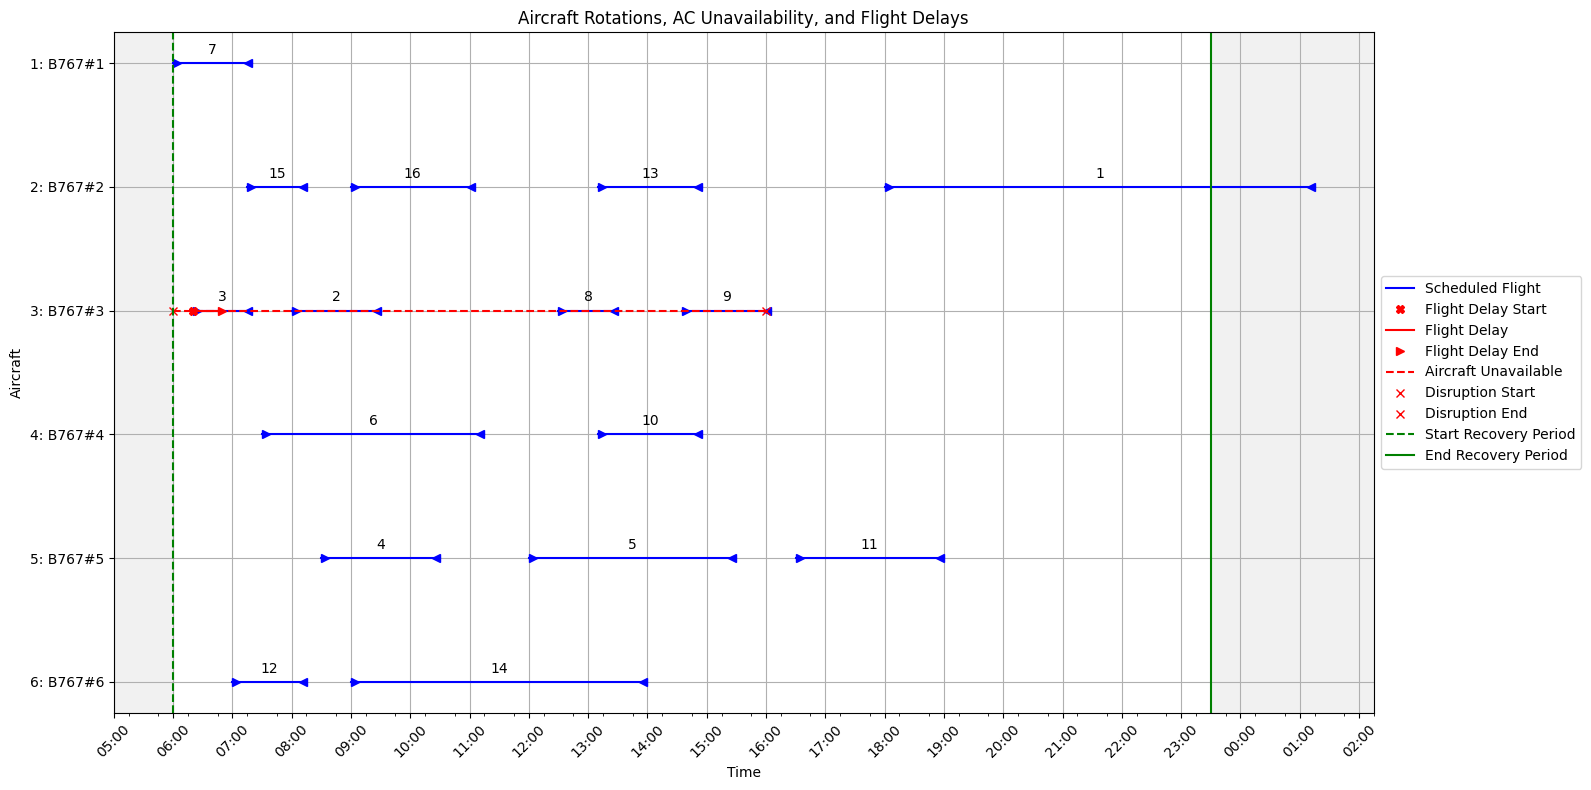

In [18]:
# AC rotations and unavailability
print("AC rotations and unavailability")
print("")
visualize_aircraft_rotations(data_dict)

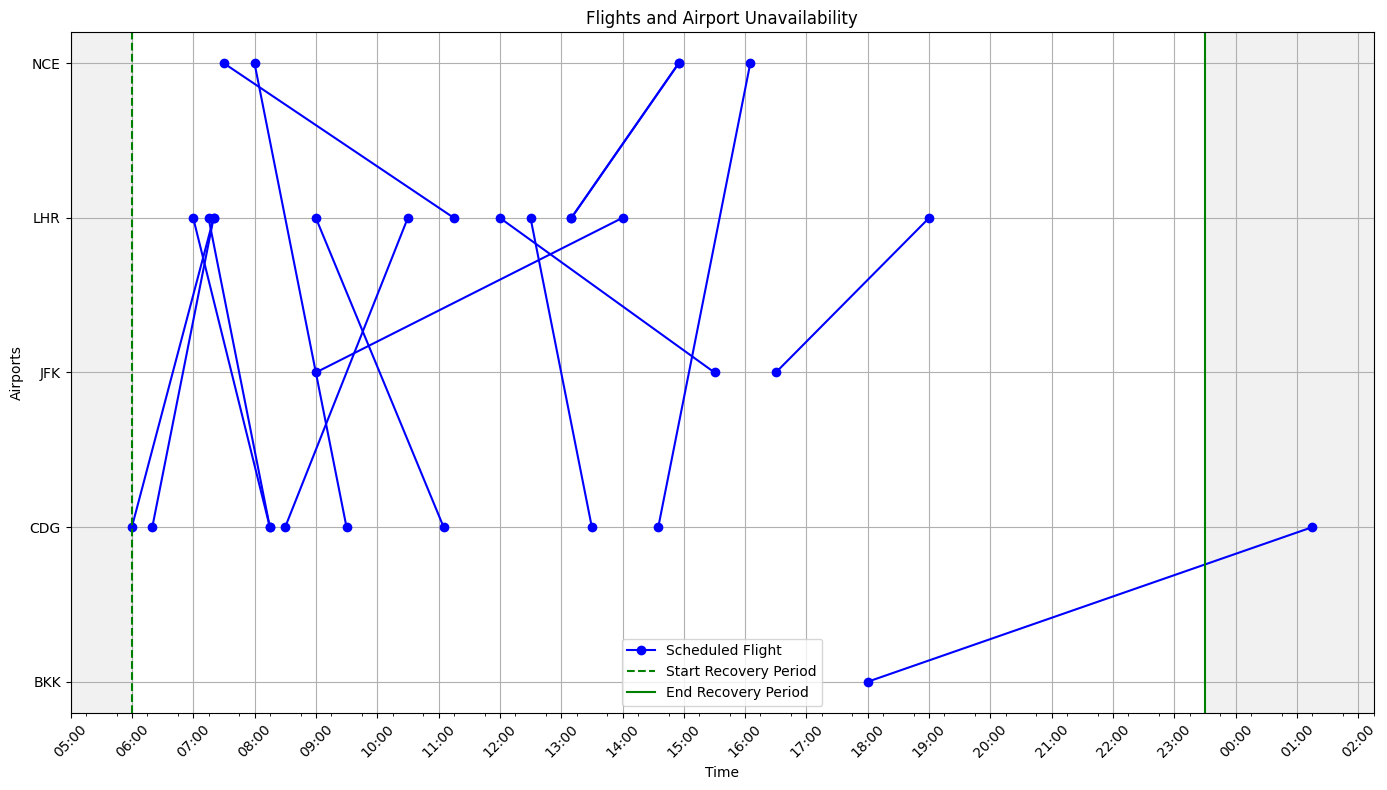

In [19]:
# Flights and airports unavailability
print("Flights and airports unavailability")
print("")
visualize_flight_airport_unavailability(data_dict)

# Reinforcement Learning

## Environment

In [20]:
import copy
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from datetime import datetime, timedelta


MAX_AIRCRAFT = 10
MAX_FLIGHTS_PER_AIRCRAFT = 10
COLUMNS_STATE_SPACE = 1 + 2 + 2 * MAX_FLIGHTS_PER_AIRCRAFT

print(COLUMNS_STATE_SPACE)

class AircraftDisruptionEnv(gym.Env):
    def __init__(self, aircraft_dict, flights_dict, rotations_dict, alt_aircraft_dict, config_dict):
        super(AircraftDisruptionEnv, self).__init__()

        # Constants for environment configuration
        self.max_aircraft = MAX_AIRCRAFT
        self.columns_state_space = COLUMNS_STATE_SPACE

        # Define the recovery period based on provided configuration
        start_date = config_dict['RecoveryPeriod']['StartDate']
        start_time = config_dict['RecoveryPeriod']['StartTime']
        end_date = config_dict['RecoveryPeriod']['EndDate']
        end_time = config_dict['RecoveryPeriod']['EndTime']
        self.start_datetime = datetime.strptime(f"{start_date} {start_time}", '%d/%m/%y %H:%M')
        self.end_datetime = datetime.strptime(f"{end_date} {end_time}", '%d/%m/%y %H:%M')
        self.timestep = timedelta(hours=1)

        # Aircraft information and indexing
        self.aircraft_ids = list(aircraft_dict.keys())
        self.aircraft_id_to_idx = {aircraft_id: idx for idx, aircraft_id in enumerate(self.aircraft_ids)}

        # Determine the earliest possible event in the environment
        self.earliest_datetime = min(
            min(parse_time_with_day_offset(flight_info['DepTime'], self.start_datetime) 
                for flight_info in flights_dict.values()), 
            self.start_datetime
        )

        # Define observation and action spaces
        self.state_space_size = (self.max_aircraft, self.columns_state_space)  # Size of the state space
        self.observation_space = spaces.Box(low=0, high=2880, shape=self.state_space_size, dtype=np.int32)  # 48 hours = 2880 minutes

        # Action space: index of the aircraft to reassign (0 to number of aircraft)
        self.full_action_space = spaces.Discrete(len(self.aircraft_ids) + 1)
        self.action_space = self.full_action_space

        # Deep copies of initial data to reset the environment later
        self.initial_aircraft_dict = copy.deepcopy(aircraft_dict)
        self.initial_flights_dict = copy.deepcopy(flights_dict)
        self.initial_rotations_dict = copy.deepcopy(rotations_dict)
        self.initial_alt_aircraft_dict = copy.deepcopy(alt_aircraft_dict)

        # Track environment state related to delays and conflicts
        self.environment_delayed_flights = {}   # Tracks delays for flights {flight_id: delay_minutes}
        self.penalized_delays = set()           # Set of penalized delays
        self.penalized_conflicts = set()        # Set of penalized conflicts
        self.resolved_conflicts = set()         # Set of resolved conflicts
        
        # Mapping from flight IDs to positions in the state space
        self.flight_id_to_state_space = {}

        # Unnormalized and normalized state representations
        self.state_unnormalized = None
        self.state = None

        # Initialize the environment state
        self.reset()


    def _get_initial_state(self, rotations_dict, flights_dict, alt_aircraft_dict, start_time, end_time):
        # Initialize state matrix with NaN values, with additional space for aircraft state info
        state = np.full((self.max_aircraft, self.columns_state_space), np.nan)

        # Calculate current time and remaining recovery period in minutes
        current_time_minutes = (self.current_datetime - self.start_datetime).total_seconds() // 60
        time_until_end_minutes = (self.end_datetime - self.current_datetime).total_seconds() // 60

        # Check for conflicts between unavailable aircraft and scheduled flights
        conflicting_aircraft_idx = -1  # Default: no conflict found
        for idx, aircraft_id in enumerate(self.aircraft_ids):
            if idx >= self.max_aircraft:
                continue

            if aircraft_id in alt_aircraft_dict:
                # Retrieve unavailability start and end times for this aircraft
                unavail_info = alt_aircraft_dict[aircraft_id]
                unavail_start_time = datetime.strptime(unavail_info['StartDate'] + ' ' + unavail_info['StartTime'], '%d/%m/%y %H:%M')
                unavail_end_time = datetime.strptime(unavail_info['EndDate'] + ' ' + unavail_info['EndTime'], '%d/%m/%y %H:%M')

                # Calculate unavailability times in minutes relative to the earliest event
                unavail_start_minutes = (unavail_start_time - self.earliest_datetime).total_seconds() // 60
                unavail_end_minutes = (unavail_end_time - self.earliest_datetime).total_seconds() // 60

                # Check aircraft rotations for conflicts with unavailability
                for rotation_id, rotation_info in rotations_dict.items():
                    if rotation_info['Aircraft'] == aircraft_id:
                        flight_info = flights_dict[rotation_id]
                        dep_time = parse_time_with_day_offset(flight_info['DepTime'], self.earliest_datetime)
                        arr_time = parse_time_with_day_offset(flight_info['ArrTime'], dep_time)

                        # Calculate flight departure and arrival times in minutes
                        dep_time_minutes = (dep_time - self.earliest_datetime).total_seconds() // 60
                        arr_time_minutes = (arr_time - self.earliest_datetime).total_seconds() // 60

                        # Determine if the flight conflicts with unavailability
                        if unavail_start_minutes <= arr_time_minutes and unavail_end_minutes >= dep_time_minutes:
                            if dep_time_minutes > current_time_minutes:
                                conflicting_aircraft_idx = idx
                                break
                if conflicting_aircraft_idx != -1:
                    break

        # Populate state matrix with aircraft and flight information
        for idx, aircraft_id in enumerate(self.aircraft_ids):
            if idx >= self.max_aircraft:
                break  # Only process up to the maximum number of aircraft

            state[idx, 0] = idx  # Store aircraft index

            # Add unavailability times (relative to the earliest event)
            if aircraft_id in alt_aircraft_dict:
                unavail_info = alt_aircraft_dict[aircraft_id]
                unavail_start_time = datetime.strptime(unavail_info['StartDate'] + ' ' + unavail_info['StartTime'], '%d/%m/%y %H:%M')
                unavail_end_time = datetime.strptime(unavail_info['EndDate'] + ' ' + unavail_info['EndTime'], '%d/%m/%y %H:%M')

                unavail_start_minutes = (unavail_start_time - self.earliest_datetime).total_seconds() // 60
                unavail_end_minutes = (unavail_end_time - self.earliest_datetime).total_seconds() // 60

                state[idx, 1] = unavail_start_minutes
                state[idx, 2] = unavail_end_minutes
            else:
                state[idx, 1] = np.nan  # No unavailability

            # Gather flight times for this aircraft within the recovery period
            flight_times = []
            for rotation_id, rotation_info in rotations_dict.items():
                if rotation_info['Aircraft'] == aircraft_id:
                    flight_info = flights_dict[rotation_id]
                    dep_time = parse_time_with_day_offset(flight_info['DepTime'], self.earliest_datetime)
                    arr_time = parse_time_with_day_offset(flight_info['ArrTime'], dep_time)

                    # Convert flight times to minutes relative to the earliest event
                    dep_time_minutes = (dep_time - self.earliest_datetime).total_seconds() // 60
                    arr_time_minutes = (arr_time - self.earliest_datetime).total_seconds() // 60
                    flight_times.append((dep_time_minutes, arr_time_minutes))

                    # Map flight ID to its location in the state space
                    self.flight_id_to_state_space[rotation_id] = (idx, len(flight_times) - 1)

            # Store flight times in the state matrix (up to 20 time entries for 10 flights)
            flight_times_flat = [time for times in flight_times for time in times]
            state[idx, 3:len(flight_times_flat) + 3] = flight_times_flat[:20]

        return state


    def step(self, action):
        assert self.action_space.contains(action), "Invalid action"

        action_explain = "No action taken" if action == 0 else f"Action: Aircraft {self.aircraft_ids[action - 1]}"
        conflicting_aircraft = None
        conflicting_flight_id = None

        conflicting_aircraft_list = []
        conflicting_flight_ids = []

        # Convert current datetime to minutes for comparison
        current_datetime = (self.current_datetime - self.earliest_datetime).total_seconds() // 60

        # Check for conflicts between aircraft unavailability and scheduled flights
        for idx, aircraft_id in enumerate(self.aircraft_ids):
            if idx >= self.max_aircraft:
                continue
            
            unavail_start = self.state[idx, 1]
            unavail_end = self.state[idx, 2]

            if not np.isnan(unavail_start) and not np.isnan(unavail_end):
                # Check for flight conflicts with unavailability
                for j in range(3, self.columns_state_space, 2):
                    flight_dep = self.state[idx, j]
                    flight_arr = self.state[idx, j + 1]

                    if not np.isnan(flight_dep) and not np.isnan(flight_arr):
                        if unavail_start <= flight_arr and unavail_end >= flight_dep:
                            conflicting_aircraft_list.append(aircraft_id)
                            id = list(self.flight_id_to_state_space.keys())[list(self.flight_id_to_state_space.values()).index((idx, (j - 3) // 2))]
                            conflicting_flight_ids.append(id)

        # Assign the conflicting aircraft and flight with the earliest time
        if conflicting_aircraft_list:
            conflicting_aircraft = conflicting_aircraft_list[0]
            conflicting_flight_id = conflicting_flight_ids[0]
            for i in range(1, len(conflicting_aircraft_list)):
                earliest_time = None
                for j in range(3, self.columns_state_space, 2):
                    if not np.isnan(self.state[self.aircraft_id_to_idx[conflicting_aircraft_list[i]], j]):
                        # Compare departure times to find the earliest conflict
                        if earliest_time is None or self.state[self.aircraft_id_to_idx[conflicting_aircraft_list[i]], j] < earliest_time:
                            earliest_time = self.state[self.aircraft_id_to_idx[conflicting_aircraft_list[i]], j]
                            conflicting_aircraft = conflicting_aircraft_list[i]
                            id = list(self.flight_id_to_state_space.keys())[list(self.flight_id_to_state_space.values()).index((self.aircraft_id_to_idx[conflicting_aircraft], (j - 3) // 2))]
                            conflicting_flight_id = id

        # No conflict found, skip agent action and advance time
        if conflicting_aircraft is None:
            action = None
            print("No conflict found. Skipping agent action.")

            next_datetime = self.current_datetime + self.timestep
            self.state = self._get_initial_state(self.rotations_dict, self.flights_dict, self.alt_aircraft_dict, next_datetime, next_datetime + self.timestep)
            self.current_datetime = next_datetime
            reward = 0  # No reward change
            done = self._is_done()
            return self.state, reward, done, False, {}

        # Verify agent action if applicable
        if action is None:
            print("Action is set to None, agent not involved.")
        else:
            print(f"Action: {action}, agent was involved.")

        conflicting_idx = self.aircraft_id_to_idx[conflicting_aircraft]

        # No action taken (action == 0)
        if action == 0:
            reward = self._calculate_reward(self.state, action)
            done = self._is_done()
            next_datetime = self.current_datetime + self.timestep
            self.state = self._get_initial_state(self.rotations_dict, self.flights_dict, self.alt_aircraft_dict, next_datetime, next_datetime + self.timestep)
            self.current_datetime = next_datetime
            return self.state, reward, done, False, {}

        selected_aircraft_id = self.aircraft_ids[action - 1]
        selected_idx = self.aircraft_id_to_idx[selected_aircraft_id]

        # If the selected aircraft is the conflicting aircraft
        if selected_aircraft_id == conflicting_aircraft:
            print("Selected Aircraft is the conflicting aircraft")
            print("selected aircraft id: ", selected_aircraft_id)
            print("conflicting aircraft id: ", conflicting_aircraft)

            self.apply_delay_to_after_unavailability(selected_aircraft_id, conflicting_flight_id)

            reward = self._calculate_reward(self.state, action)
            done = self._is_done()
            next_datetime = self.current_datetime + self.timestep
            self.state = self._get_initial_state(self.rotations_dict, self.flights_dict, self.alt_aircraft_dict, next_datetime, next_datetime + self.timestep)
            self.current_datetime = next_datetime
            return self.state, reward, done, False, {}

        # Swap the conflicting flight to the selected aircraft
        if conflicting_flight_id:
            self.swapped_flights.append((conflicting_flight_id, selected_aircraft_id))

            # Update the rotation dict to reflect the swap
            self.rotations_dict[conflicting_flight_id]['Aircraft'] = selected_aircraft_id

            self.state[conflicting_idx, 3:23] = np.nan  # Clear old flight data for the conflicting aircraft
            self.state[selected_idx, 3:23] = self.state[conflicting_idx, 3:23]  # Assign flights to the selected aircraft

            # Apply delay to the most suitable flight
            self.determine_and_apply_best_delay(selected_aircraft_id, conflicting_flight_id)

        next_datetime = self.current_datetime + self.timestep
        self.state = self._get_initial_state(self.rotations_dict, self.flights_dict, self.alt_aircraft_dict, next_datetime, next_datetime + self.timestep)
        self.current_datetime = next_datetime

        print("Calling reward function now!")
        reward = self._calculate_reward(self.state, action)
        done = self._is_done()
        print("Is the episode done?", done)

        return self.state, reward, done, False, {}



    def check_and_resolve_conflicts(self, aircraft_id, selected_idx):
        conflicts_found = True
        while conflicts_found:
            conflicts_found = False
            for rotation_id, rotation_info in self.rotations_dict.items():
                if rotation_info['Aircraft'] == aircraft_id:
                    flight_info = self.flights_dict[rotation_id]
                    dep_time = parse_time_with_day_offset(flight_info['DepTime'], self.current_datetime)
                    arr_time = parse_time_with_day_offset(flight_info['ArrTime'], dep_time)

                    for other_rotation_id, other_rotation_info in self.rotations_dict.items():
                        if other_rotation_id != rotation_id and other_rotation_info['Aircraft'] == aircraft_id:
                            other_flight_info = self.flights_dict[other_rotation_id]
                            other_dep_time = parse_time_with_day_offset(other_flight_info['DepTime'], self.current_datetime)
                            other_arr_time = parse_time_with_day_offset(other_flight_info['ArrTime'], other_dep_time)

                            if other_dep_time < arr_time and other_arr_time > dep_time:
                                conflict_identifier = (aircraft_id, dep_time, arr_time)

                                if conflict_identifier not in self.penalized_conflicts:
                                    self.determine_and_apply_best_delay(aircraft_id, rotation_id)
                                    conflicts_found = True
                                    break



    def determine_and_apply_best_delay(self, selected_aircraft_id, conflicting_flight_id):
        print(f"[DEBUG] selected_aircraft_id: {selected_aircraft_id} conflicting_flight_id: {conflicting_flight_id}")
        conflicting_flight_info = self.flights_dict[conflicting_flight_id]
        conf_dep_time = parse_time_with_day_offset(conflicting_flight_info['DepTime'], self.current_datetime)
        conf_arr_time = parse_time_with_day_offset(conflicting_flight_info['ArrTime'], conf_dep_time)

        for other_rotation_id, other_rotation_info in self.rotations_dict.items():
            if other_rotation_info['Aircraft'] == selected_aircraft_id and other_rotation_id != conflicting_flight_id:
                print(f"[DEBUG] Checking conflict between {conflicting_flight_id} and {other_rotation_id}")
                other_flight_info = self.flights_dict[other_rotation_id]
                other_dep_time = parse_time_with_day_offset(other_flight_info['DepTime'], self.current_datetime)
                other_arr_time = parse_time_with_day_offset(other_flight_info['ArrTime'], other_dep_time)

                if other_dep_time < conf_arr_time and other_arr_time > conf_dep_time:
                    print(f"[DEBUG] Conflict found between {conflicting_flight_id} and {other_rotation_id}")
                    delay_other = (conf_arr_time - other_dep_time).total_seconds() // 60
                    delay_conf = (other_arr_time - conf_dep_time).total_seconds() // 60
                    
                    delay_other = max(0, delay_other)
                    delay_conf = max(0, delay_conf)

                    print(f" -- the delay would be {delay_other} for {other_rotation_id} and {delay_conf} for {conflicting_flight_id}")

                    if delay_other < delay_conf:
                        print(f"[DEBUG] Delaying {other_rotation_id} by {delay_other} minutes")
                        new_dep_time = other_dep_time + timedelta(minutes=delay_other)
                        new_arr_time = other_arr_time + timedelta(minutes=delay_other)
                        self.flights_dict[other_rotation_id]['DepTime'] = self._convert_time_to_str(new_dep_time)
                        self.flights_dict[other_rotation_id]['ArrTime'] = self._convert_time_to_str(new_arr_time)
                        self.environment_delayed_flights[other_rotation_id] = delay_other
                    else:
                        # print(f"[DEBUG] Delaying {conflicting_flight_id} by {delay_conf} minutes")
                        new_conf_dep_time = conf_dep_time + timedelta(minutes=delay_conf)
                        new_conf_arr_time = conf_arr_time + timedelta(minutes=delay_conf)
                        self.flights_dict[conflicting_flight_id]['DepTime'] = self._convert_time_to_str(new_conf_dep_time)
                        self.flights_dict[conflicting_flight_id]['ArrTime'] = self._convert_time_to_str(new_conf_arr_time)
                        self.environment_delayed_flights[conflicting_flight_id] = delay_conf
                    
                    # Recursively check for any further conflicts introduced by the delay
                    self.check_and_resolve_conflicts(selected_aircraft_id, self.aircraft_id_to_idx[selected_aircraft_id])
                    break

        # Check for any further conflicts introduced by the delay
        self.check_and_resolve_conflicts(selected_aircraft_id, self.aircraft_id_to_idx[selected_aircraft_id])

    def apply_delay_to_after_unavailability(self, selected_aircraft_id, conflicting_flight_id):
        print(f"[DEBUG] selected_aircraft_id: {selected_aircraft_id} conflicting_flight_id: {conflicting_flight_id}")
        print(f"[DEBUG] Applying delay to after unavailability period")
        
        conflicting_flight_info = self.flights_dict[conflicting_flight_id]
        conf_dep_time = parse_time_with_day_offset(conflicting_flight_info['DepTime'], self.current_datetime)
        conf_arr_time = parse_time_with_day_offset(conflicting_flight_info['ArrTime'], conf_dep_time)

        # Get unavailability start and end times from the state space
        unavail_start = self.state[self.aircraft_id_to_idx[selected_aircraft_id], 1]
        unavail_end = self.state[self.aircraft_id_to_idx[selected_aircraft_id], 2]

        # Get the conflicting flight departure and arrival times from the state space
        conflicting_flight_dep = self.state[self.aircraft_id_to_idx[selected_aircraft_id], 3 + 2 * self.flight_id_to_state_space[conflicting_flight_id][1]]
        conflicting_flight_arr = self.state[self.aircraft_id_to_idx[selected_aircraft_id], 4 + 2 * self.flight_id_to_state_space[conflicting_flight_id][1]]

        
        # Calculate the delay required to resolve the conflict
        delay = (unavail_end - conflicting_flight_dep) + 1
        print(f" -- Delaying {conflicting_flight_id} by {delay} minutes")

        

        # Apply the delay to the conflicting flight
        new_dep_time = conf_dep_time + timedelta(minutes=delay)
        new_arr_time = conf_arr_time + timedelta(minutes=delay)
        self.flights_dict[conflicting_flight_id]['DepTime'] = self._convert_time_to_str(new_dep_time)
        self.flights_dict[conflicting_flight_id]['ArrTime'] = self._convert_time_to_str(new_arr_time)
        self.environment_delayed_flights[conflicting_flight_id] = delay

        # Recursively check for any further conflicts introduced by the delay
        self.check_and_resolve_conflicts(selected_aircraft_id, self.aircraft_id_to_idx[selected_aircraft_id])

        

    def _convert_time_to_str(self, time_obj):
        time_str = time_obj.strftime('%H:%M')
        if time_obj.date() > self.current_datetime.date():
            time_str += ' +1'
        return time_str
    


    def _calculate_reward(self, state, action):

        # Initialize reward
        reward = 0

        conflicts = 0
        current_conflicts = set()
        newly_resolved_conflicts = 0

        # Track current conflicts across all aircraft
        for idx, aircraft_id in enumerate(self.aircraft_ids):
            if idx >= self.max_aircraft:
                break
            if not np.isnan(state[idx, 1]) and not np.isnan(state[idx, 2]):
                # Check for conflicts between flights and unavailability periods
                for j in range(3, self.columns_state_space, 2):
                    flight_dep = state[idx, j]
                    flight_arr = state[idx, j + 1]
                    if not np.isnan(flight_dep) and not np.isnan(flight_arr):
                        if flight_dep < state[idx, 2] and flight_arr > state[idx, 1]:
                            conflict_identifier = (aircraft_id, flight_dep, flight_arr)
                            current_conflicts.add(conflict_identifier)

        # Apply conflict penalty if the selected action involves a conflicting aircraft
        if current_conflicts:
            # Penalize if no action is taken or if the selected aircraft has conflicts
            if action == 0 or self.aircraft_ids[action - 1] in {aircraft_id for aircraft_id, _, _ in current_conflicts}:
                conflicts = len(current_conflicts)
                reward -= 500 * conflicts  # Penalize based on the number of conflicts
            else:
                reward += 1000  # Reward for resolving conflicts

        # Identify newly resolved conflicts and apply rewards
        for conflict in self.penalized_conflicts:
            if conflict not in current_conflicts and conflict not in self.resolved_conflicts:
                newly_resolved_conflicts += 1
                self.resolved_conflicts.add(conflict)  # Mark conflict as resolved

        # Update penalized conflicts to the current conflicts
        self.penalized_conflicts = current_conflicts

        # Calculate delay penalties for each delayed flight
        delay_penalty = 0
        for flight_id, delay in self.environment_delayed_flights.items():
            if flight_id not in self.penalized_delays:
                delay_penalty += delay
                self.penalized_delays.add(flight_id)  # Mark delay as penalized

        # Apply penalties for unresolved conflicts and delays
        if conflicts > 0 and (action == 0 or action in {aircraft_id for aircraft_id, _, _ in current_conflicts}):
            reward -= 1000 * conflicts  # Additional conflict penalty if conflicts persist

        reward -= delay_penalty * 5  # Penalize for delays

        # Reward for resolving newly identified conflicts
        reward += 5000 * newly_resolved_conflicts

        # Return the final reward value
        return reward

 



    def _is_done(self):
        return self.current_datetime >= self.end_datetime



    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
        else:
            np.random.seed()  # This will seed with the current time or entropy source, making it random
        self.current_datetime = self.start_datetime

        self.actions_taken = set()  # Reset the actions taken at the beginning of each episode
    
        # Deep copy the initial dictionaries to reset them
        self.aircraft_dict = copy.deepcopy(self.initial_aircraft_dict)
        self.flights_dict = copy.deepcopy(self.initial_flights_dict)
        self.rotations_dict = copy.deepcopy(self.initial_rotations_dict)
        self.alt_aircraft_dict = copy.deepcopy(self.initial_alt_aircraft_dict)
    


        self.state = self._get_initial_state(self.rotations_dict, self.flights_dict, self.alt_aircraft_dict, self.current_datetime, self.current_datetime + self.timestep)
        self.swapped_flights = []  # Reset the swapped flights list
        self.environment_delayed_flights = {}  # Reset the delayed flights list
        self.penalized_delays = set()  # Reset the penalized delays
        self.penalized_conflicts = set()
        return self.state, {}

    def get_valid_actions(self):
        # print("All actions:")
        valid_actions = [0]  # No action is always valid
        # print("    0. No action: VALID. Always valid.")

        # Add all aircraft actions
        for idx, aircraft_id in enumerate(self.aircraft_ids):
            if idx >= self.max_aircraft:
                break
            valid_actions.append(idx + 1)
            # print(f"    {idx + 1}. Swap to Aircraft {aircraft_id}")

        return valid_actions
    



## Agents

### Random Agent

In [21]:
# Simple agent example
class RandomAgent:
    def __init__(self, action_space):
        self.action_space = action_space

    def choose_action(self, state, valid_actions):
        chosen_action = np.random.choice(valid_actions)
        return chosen_action

    def learn(self, state, action, reward, next_state):
        pass  # No learning for the random agent



### DQN Agent

# Run

## Visualisation Final Result

In [22]:
import torch as th
import gymnasium as gym
import numpy as np
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.pyplot as plt

# Ensure your environment is registered
env = AircraftDisruptionEnv(aircraft_dict, flights_dict, rotations_dict, alt_aircraft_dict, config_dict)

# Wrap the environment in a DummyVecEnv for compatibility with stable-baselines3
env = DummyVecEnv([lambda: env])

from stable_baselines3.common.utils import set_random_seed


n_episodes = 750
epsilon_start = 1.0
epsilon_min = 0.05
decay_rate = 0.0005
rewards = []
actions_taken = []
epsilon_values = np.zeros(n_episodes)



model = DQN(
    "MlpPolicy",
    env,
    learning_rate=1e-3,
    buffer_size=50000, 
    learning_starts=1000, # increase the learning starts to allow for more exploration
    batch_size=32,
    gamma=0.99,
    tau=1.0,
    target_update_interval=500,  # increasing the target update interval to allow for more exploration
    train_freq=(1, "step"),
    gradient_steps=1,
    exploration_fraction=0.1,
    exploration_initial_eps=1.0,
    exploration_final_eps=0.05,
    policy_kwargs=dict(net_arch=[128, 128]),
    verbose=1,
    tensorboard_log="./dqn_aircraft_disruption_tensorboard/",
)





for episode in range(n_episodes):
    obs = env.reset()
    episode_reward = 0
    done = False
    while not done:
        epsilon = epsilon_min + (epsilon_start - epsilon_min) * np.exp(-decay_rate * episode)
        epsilon_values[episode] = epsilon
        if np.random.rand() < epsilon:
            if len(actions_taken) > 1 and actions_taken[-1] == actions_taken[-2]:
                epsilon *= 1.1  # Increase exploration probability if the same action was repeated
            action = [env.action_space.sample()]  # Random action
        else:
            action, _ = model.predict(obs, deterministic=False)  # Model action

            # print(f"Model Action Selected: {action}")

        # print(f"Action: {action}")

        # unpack the action from the list and append to actions_taken
        actions_taken.append(action[0])

        obs, reward, done, _ = env.step(action)
        episode_reward += reward
    rewards.append(episode_reward)

    print(f"Episode {episode}/{n_episodes}: reward={episode_reward}")

    # print the last episode
    if episode == n_episodes - 1:
        # Access the underlying environment
        real_env = env.envs[0]

        # # Plot the final state of the environment
        # state_plotter = StatePlotter(
        #     aircraft_dict, flights_dict, rotations_dict, alt_aircraft_dict, 
        #     real_env.start_datetime, real_env.end_datetime
        # )
        # state_plotter.plot_state(
        #     real_env.flights_dict, real_env.swapped_flights, 
        #     real_env.environment_delayed_flights, real_env.current_datetime
        # )
        continue


# Save the model
model.save("dqn_aircraft_disruption")


/Users/pieterbecking/.pyenv/versions/thesis_env/lib/python3.10/site-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:108: RuntimeWarning: invalid value encountered in cast
  self.buf_obs[key][env_idx] = obs


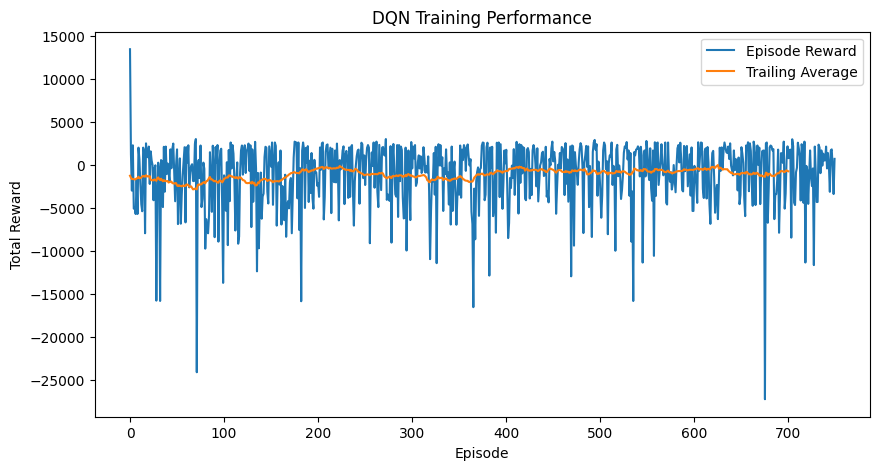

/Users/pieterbecking/.pyenv/versions/thesis_env/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


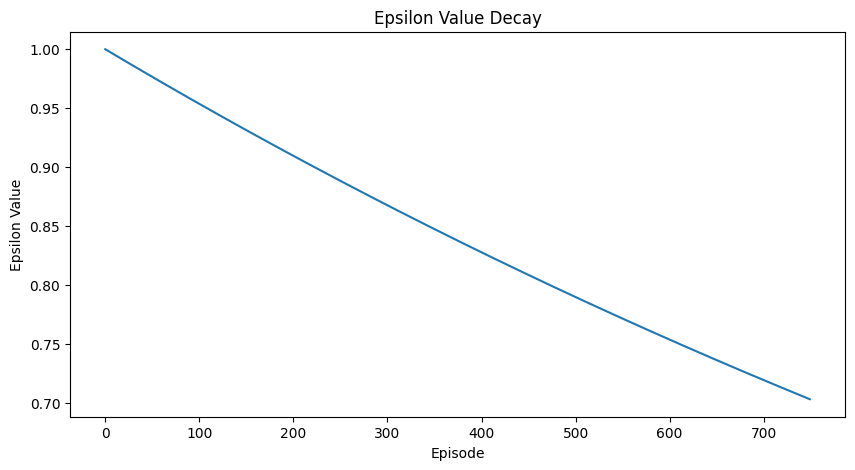

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scripts.visualizations import plot_dqn_performance

mean_reward, std_reward = plot_dqn_performance(rewards, epsilon_values, model, env, window=50, n_eval_episodes=5)

print(f"Mean Reward: {mean_reward:.2f} +/- {std_reward:.2f}")




## Testing the model

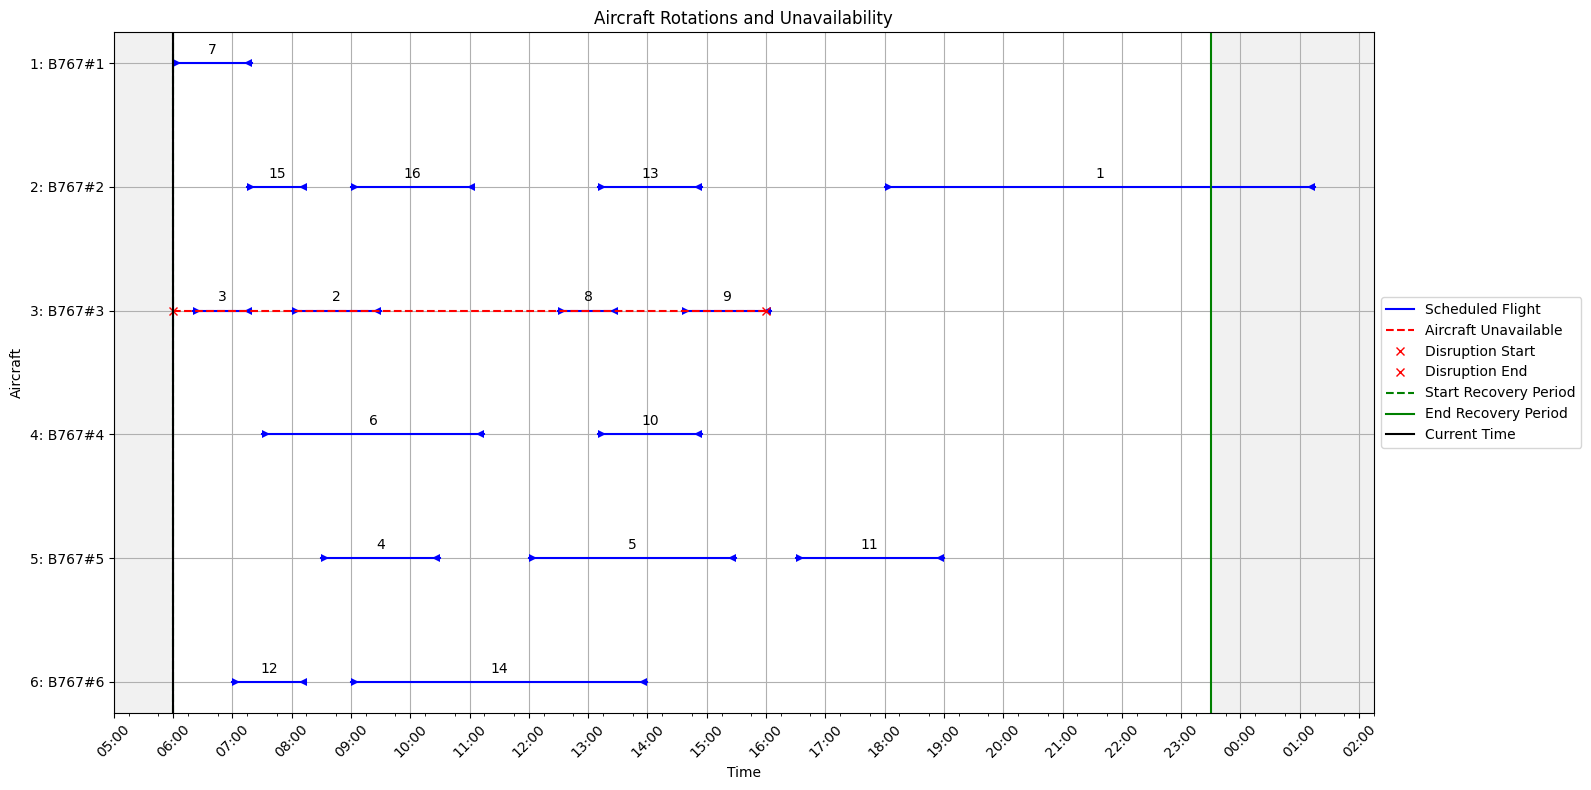

/Users/pieterbecking/.pyenv/versions/thesis_env/lib/python3.10/site-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:108: RuntimeWarning: invalid value encountered in cast
  self.buf_obs[key][env_idx] = obs


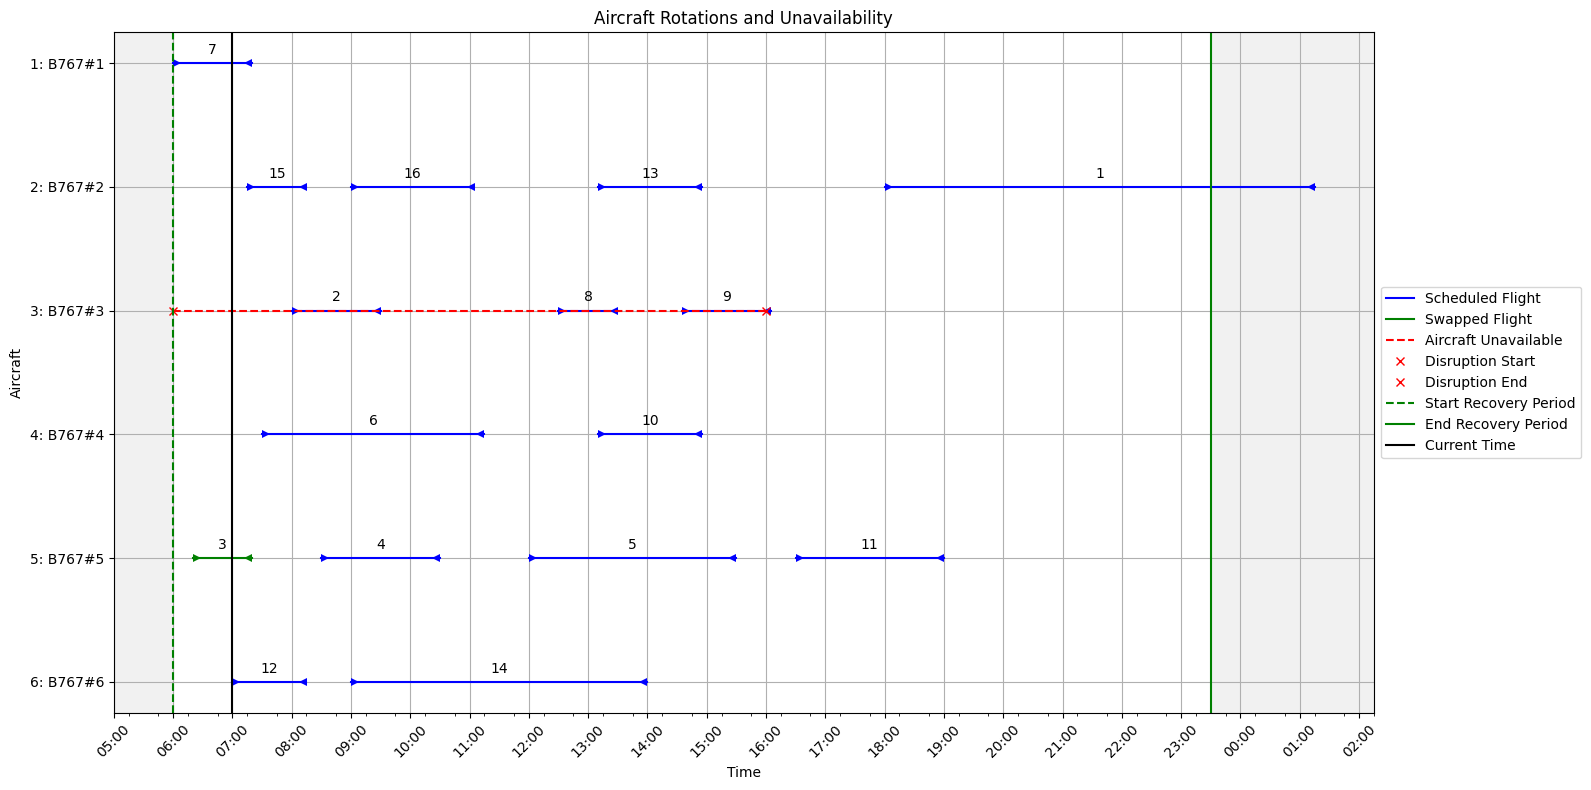

/Users/pieterbecking/.pyenv/versions/thesis_env/lib/python3.10/site-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:108: RuntimeWarning: invalid value encountered in cast
  self.buf_obs[key][env_idx] = obs


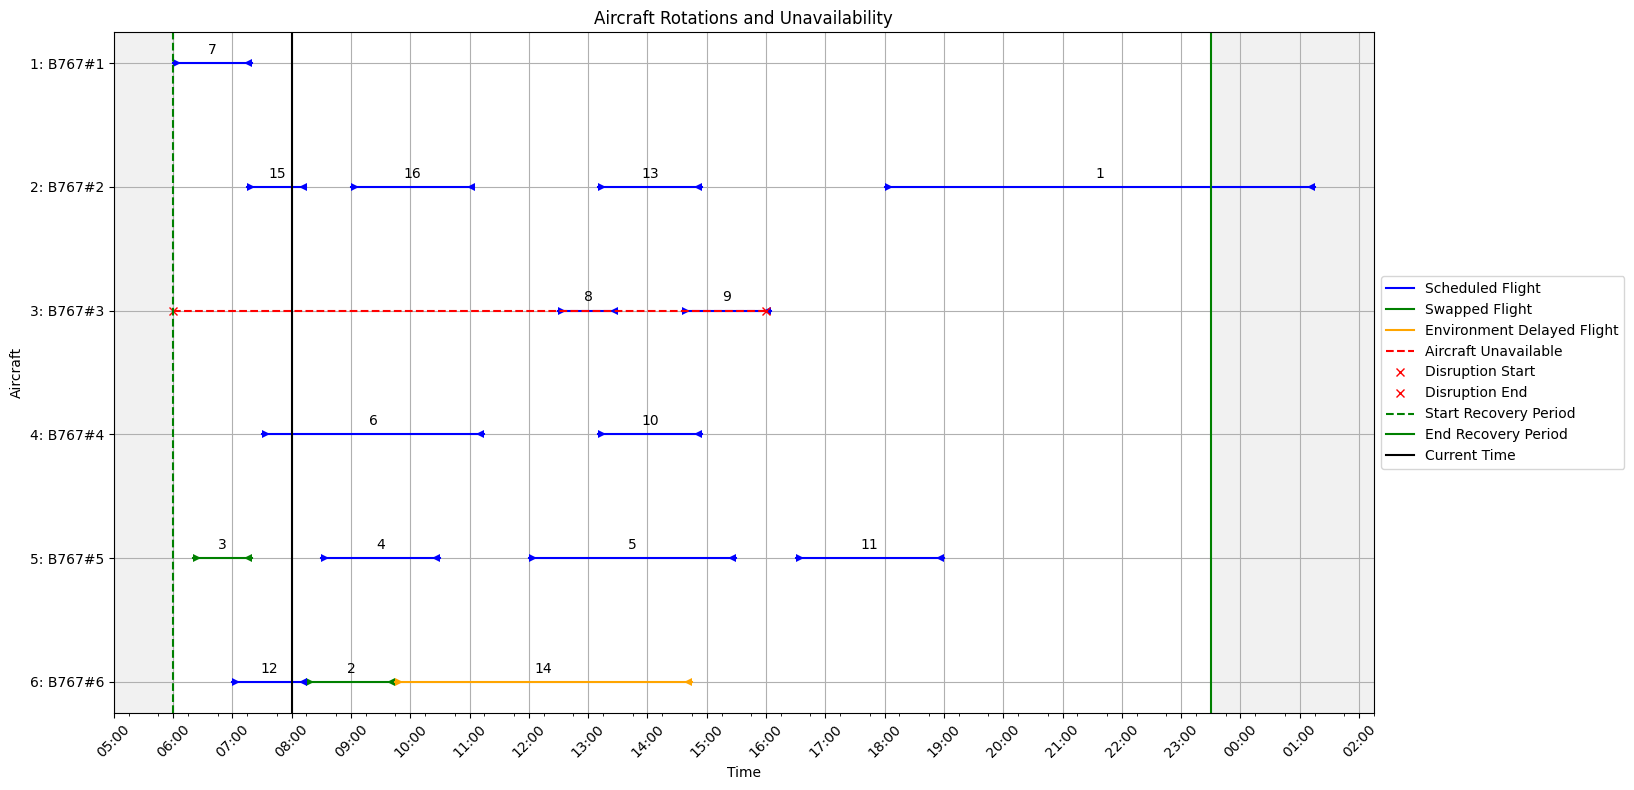

/Users/pieterbecking/.pyenv/versions/thesis_env/lib/python3.10/site-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:108: RuntimeWarning: invalid value encountered in cast
  self.buf_obs[key][env_idx] = obs


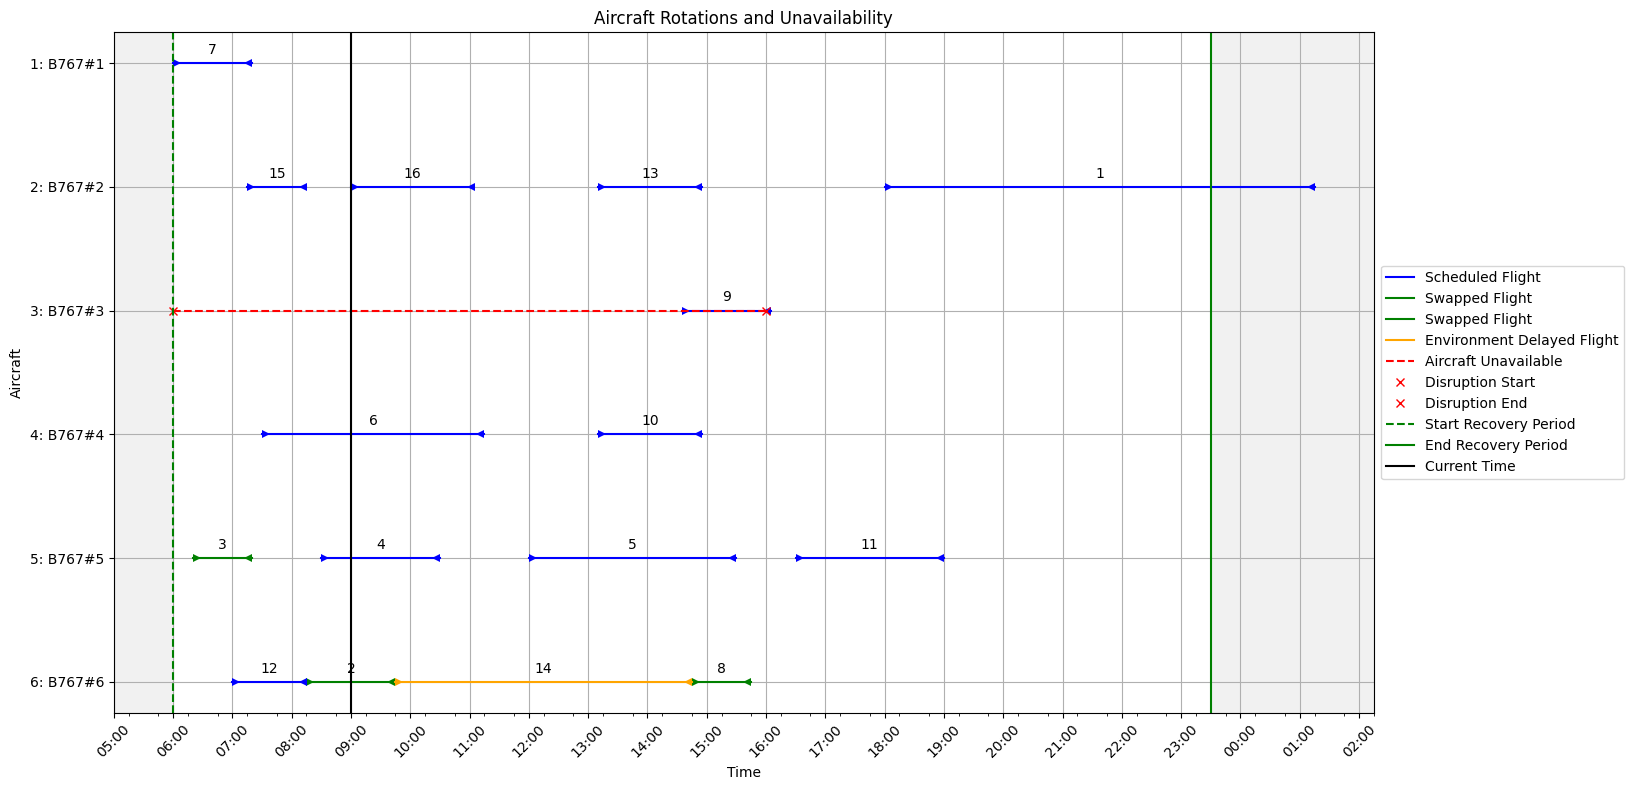

/Users/pieterbecking/.pyenv/versions/thesis_env/lib/python3.10/site-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:108: RuntimeWarning: invalid value encountered in cast
  self.buf_obs[key][env_idx] = obs


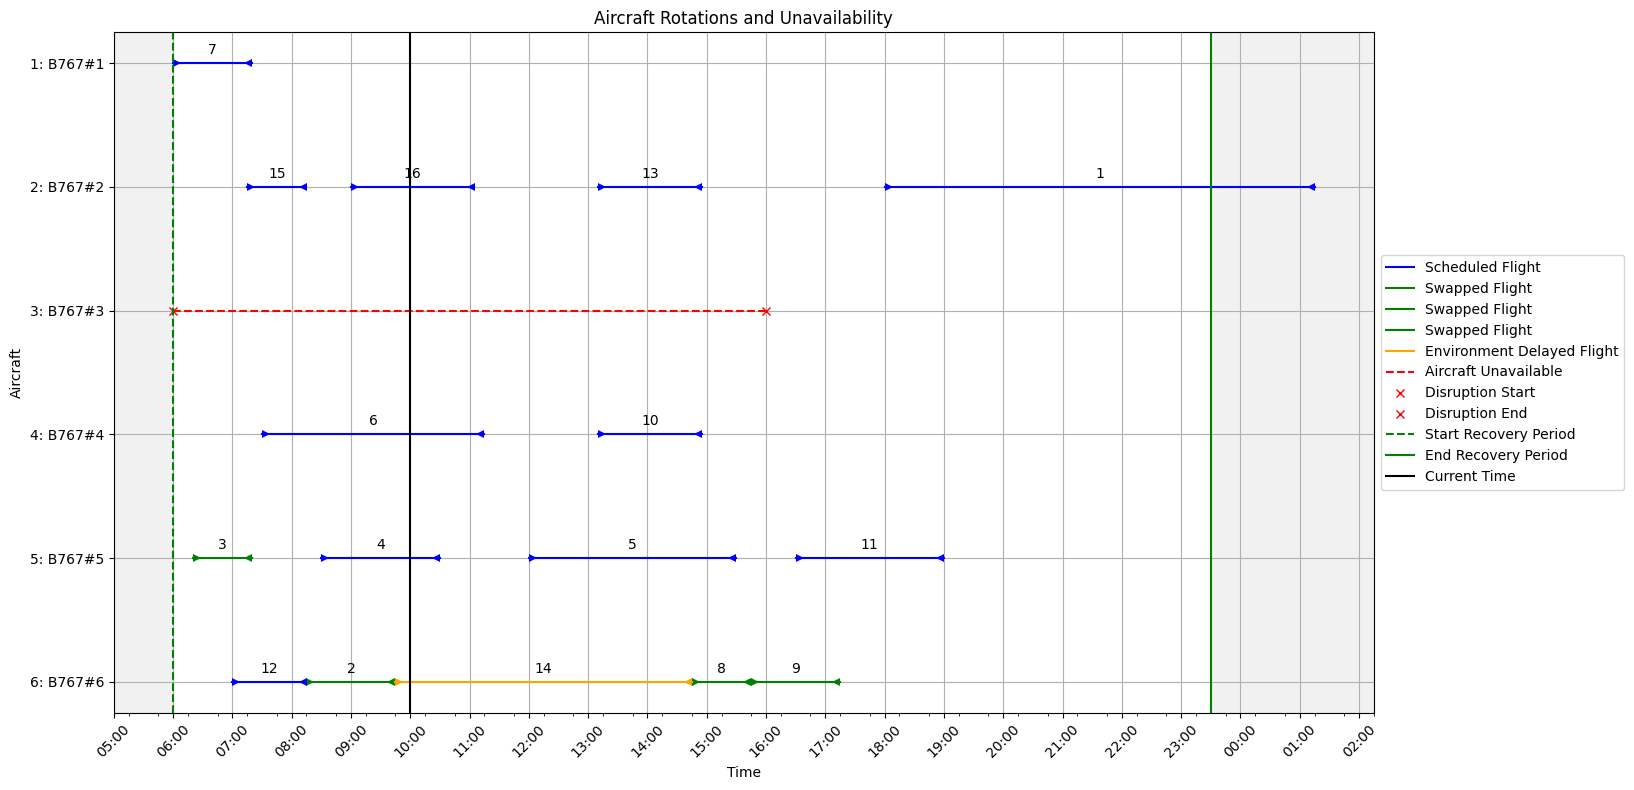

/Users/pieterbecking/.pyenv/versions/thesis_env/lib/python3.10/site-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:108: RuntimeWarning: invalid value encountered in cast
  self.buf_obs[key][env_idx] = obs


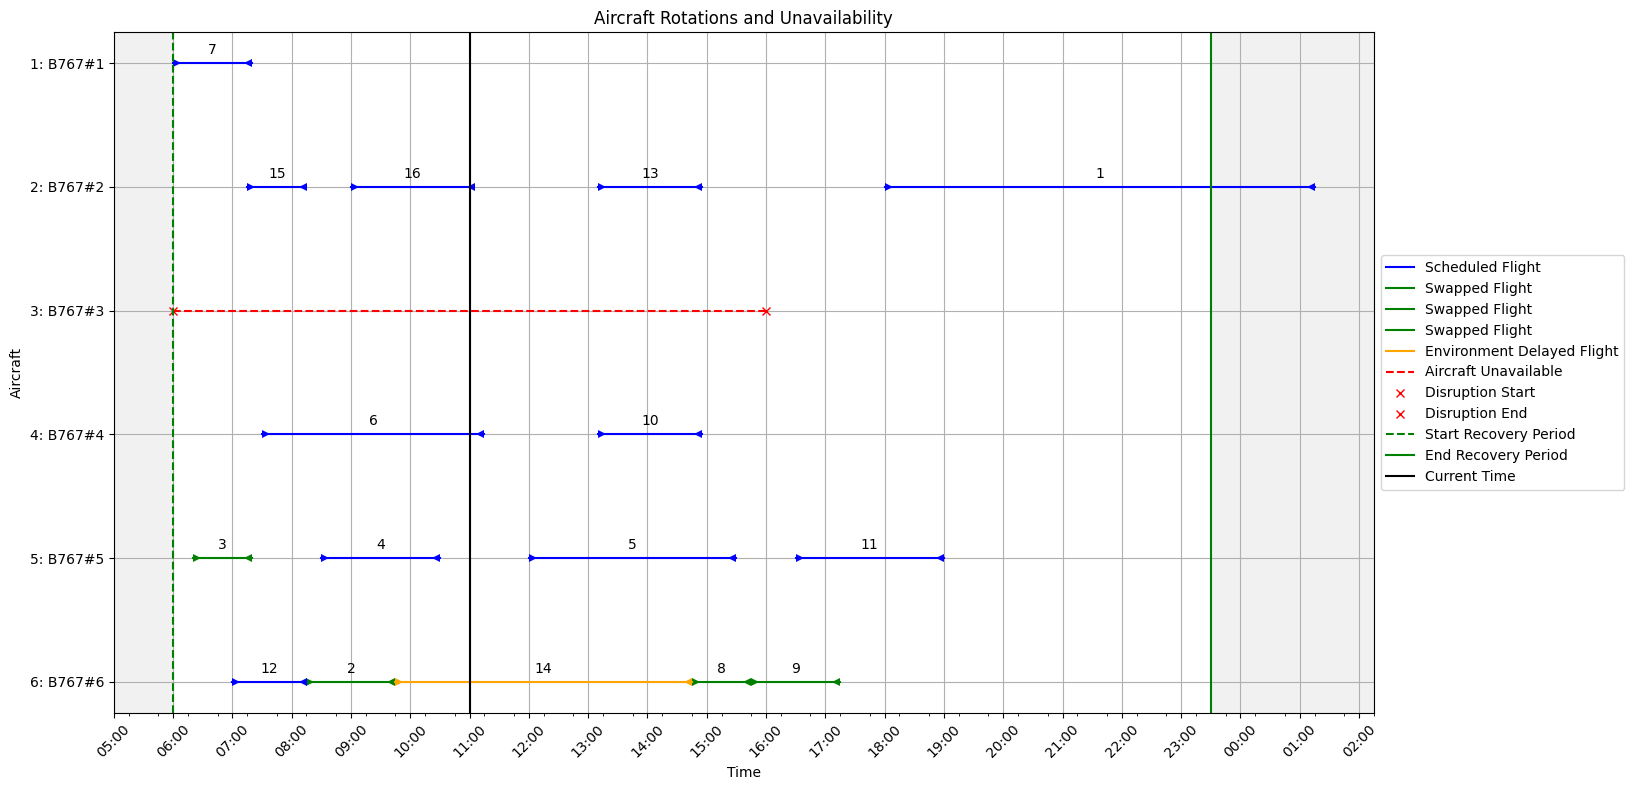

/Users/pieterbecking/.pyenv/versions/thesis_env/lib/python3.10/site-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:108: RuntimeWarning: invalid value encountered in cast
  self.buf_obs[key][env_idx] = obs


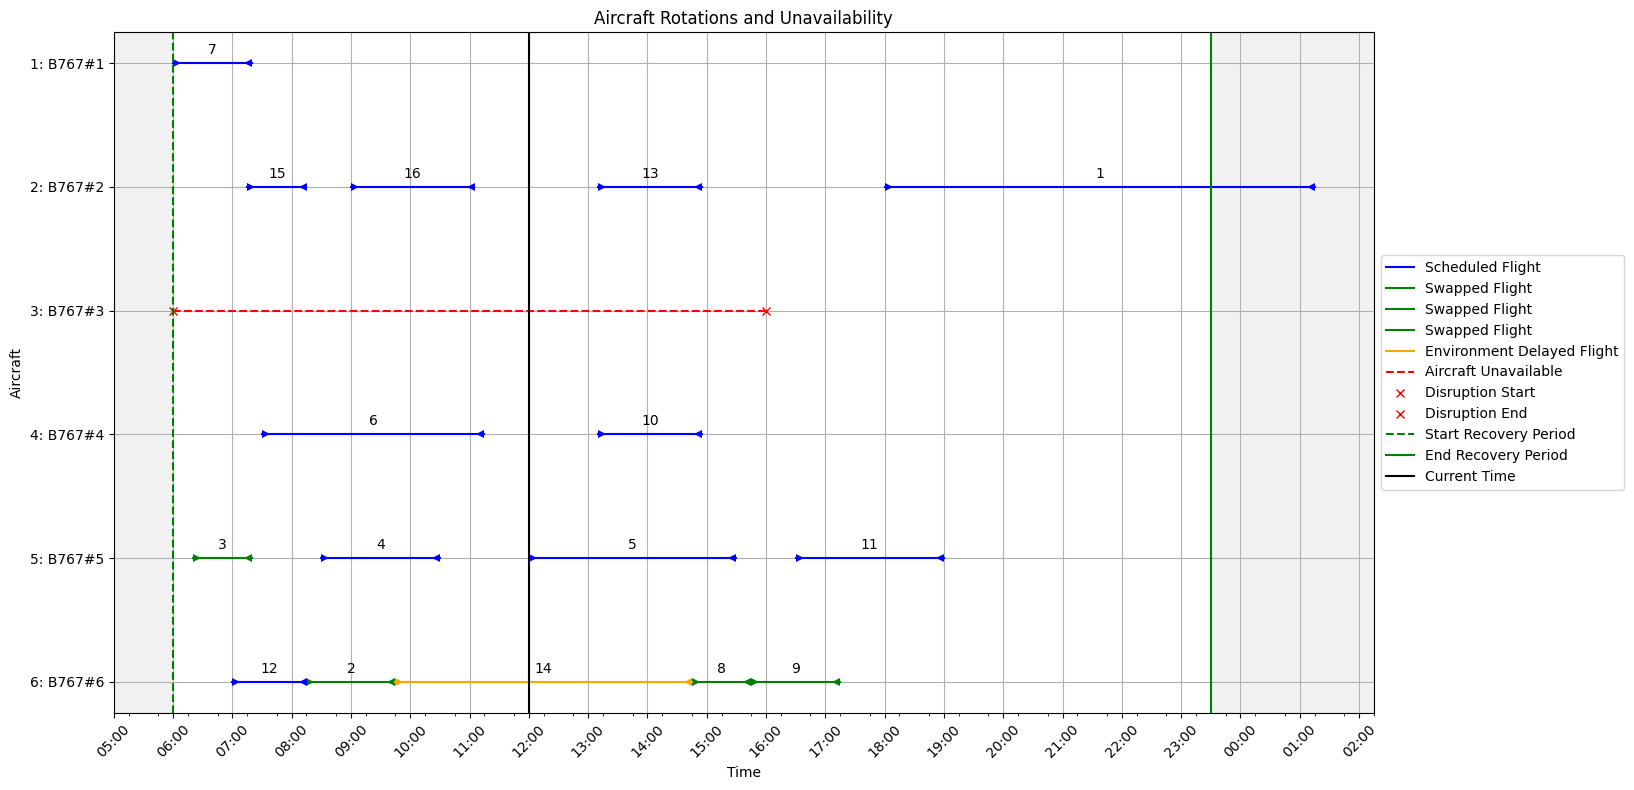

/Users/pieterbecking/.pyenv/versions/thesis_env/lib/python3.10/site-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:108: RuntimeWarning: invalid value encountered in cast
  self.buf_obs[key][env_idx] = obs


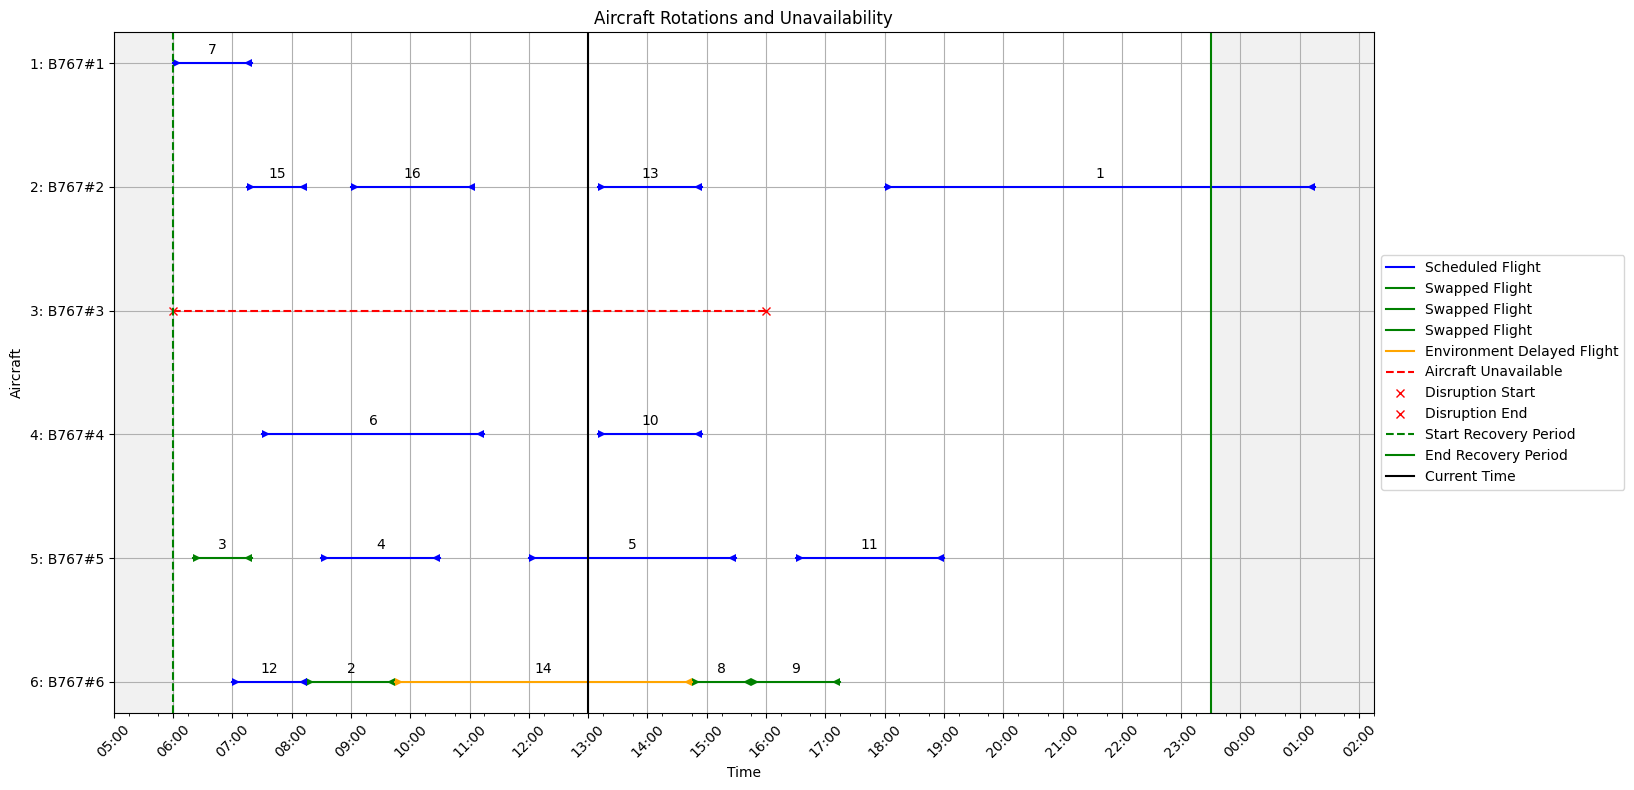

/Users/pieterbecking/.pyenv/versions/thesis_env/lib/python3.10/site-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:108: RuntimeWarning: invalid value encountered in cast
  self.buf_obs[key][env_idx] = obs


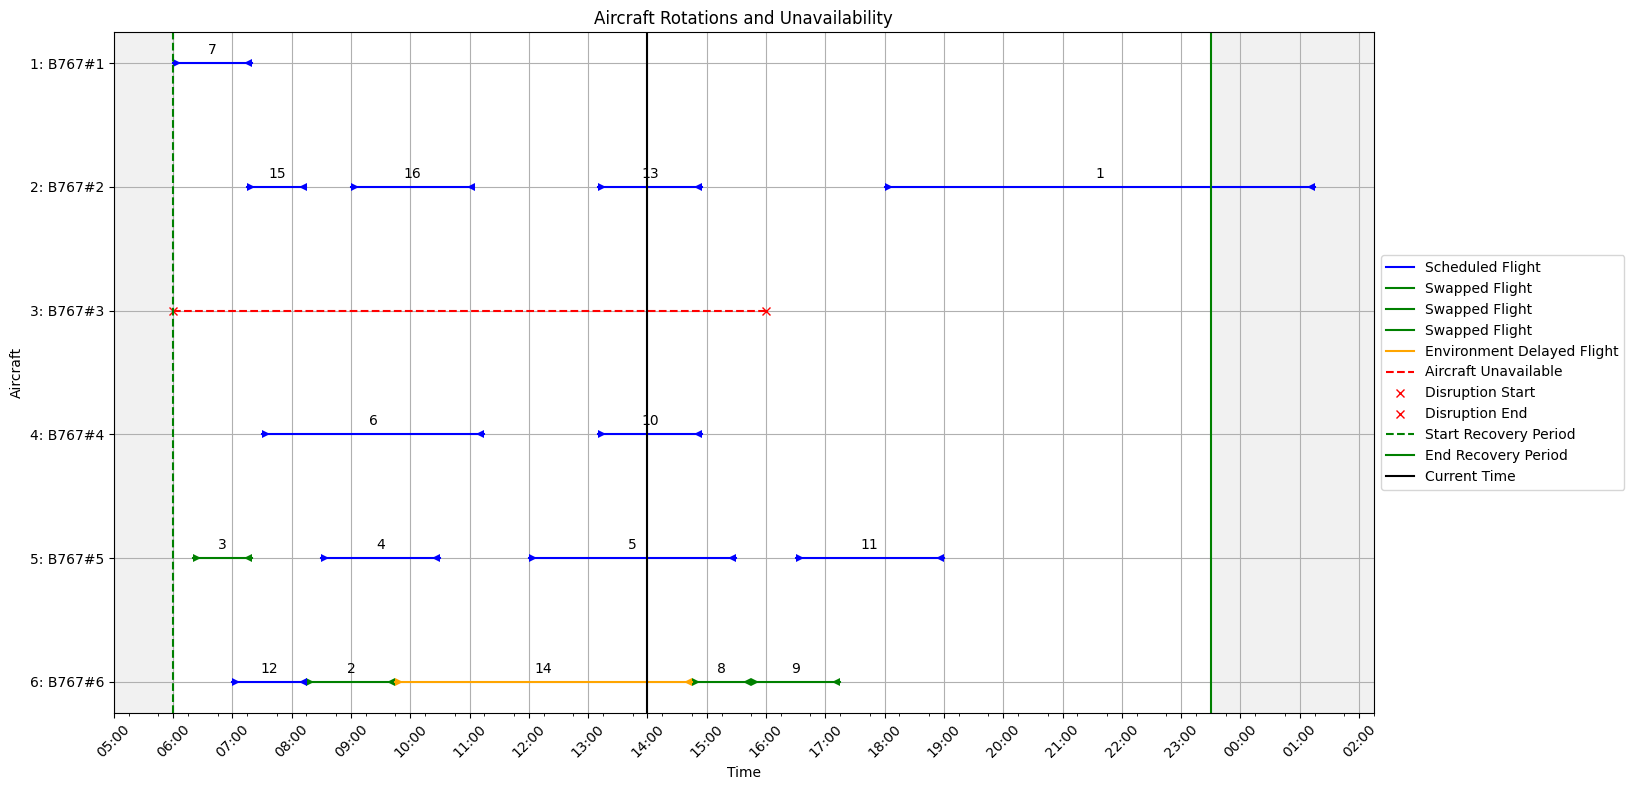

/Users/pieterbecking/.pyenv/versions/thesis_env/lib/python3.10/site-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:108: RuntimeWarning: invalid value encountered in cast
  self.buf_obs[key][env_idx] = obs


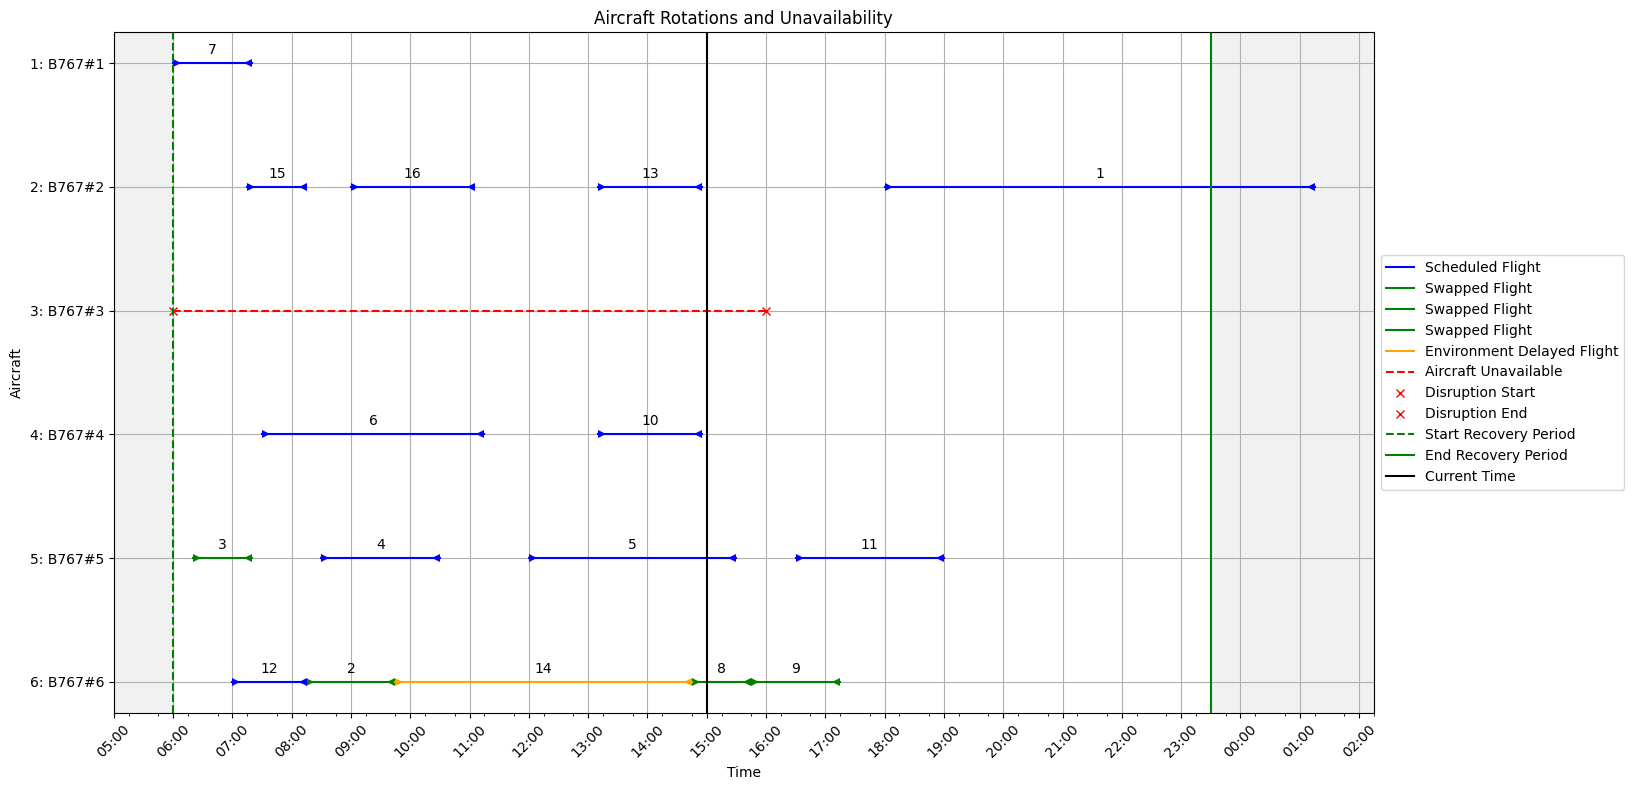

/Users/pieterbecking/.pyenv/versions/thesis_env/lib/python3.10/site-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:108: RuntimeWarning: invalid value encountered in cast
  self.buf_obs[key][env_idx] = obs


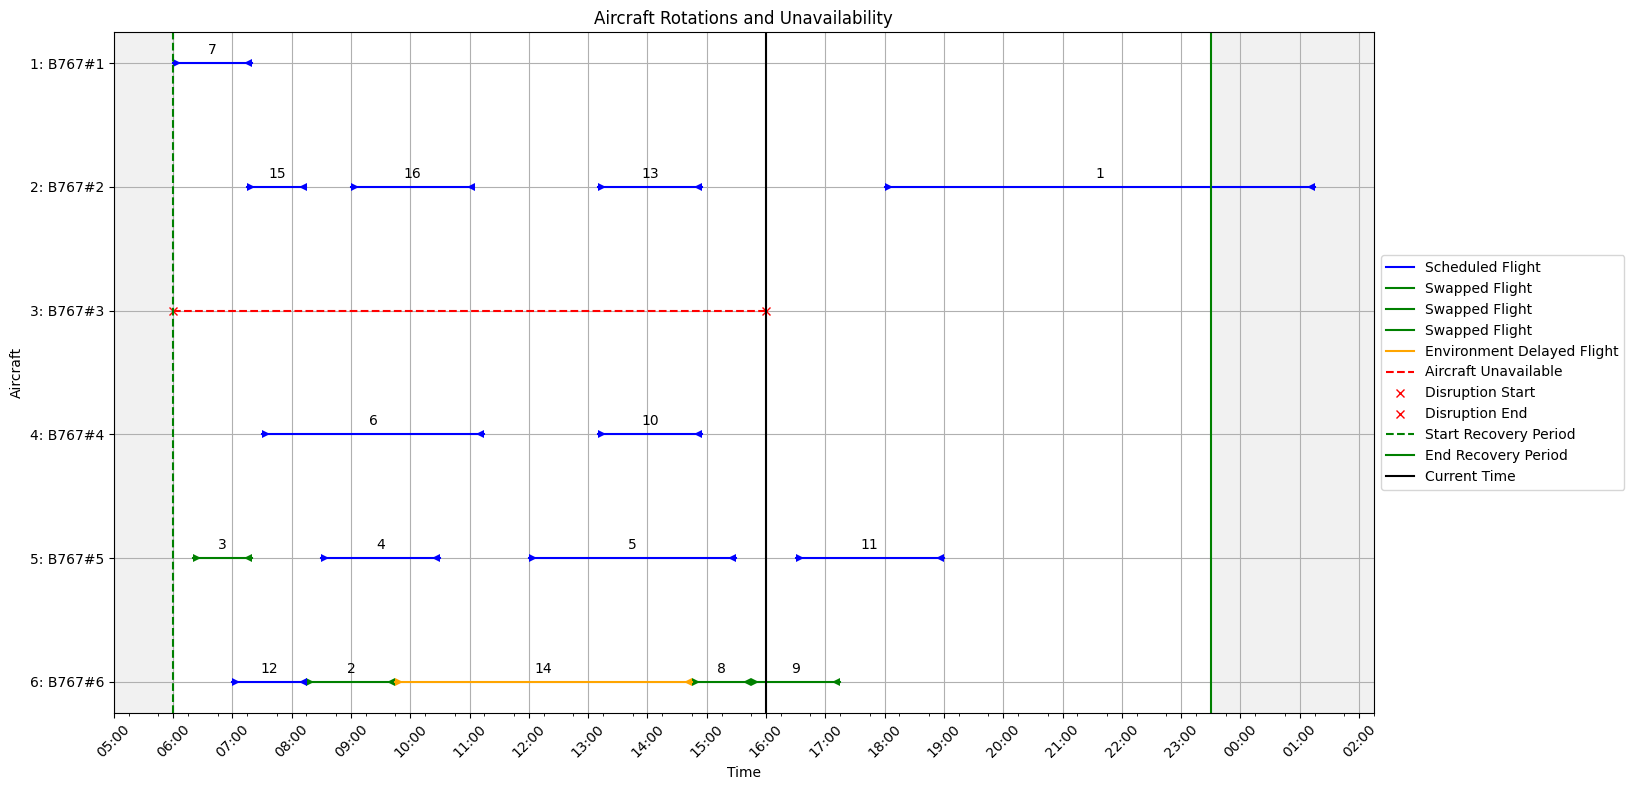

/Users/pieterbecking/.pyenv/versions/thesis_env/lib/python3.10/site-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:108: RuntimeWarning: invalid value encountered in cast
  self.buf_obs[key][env_idx] = obs


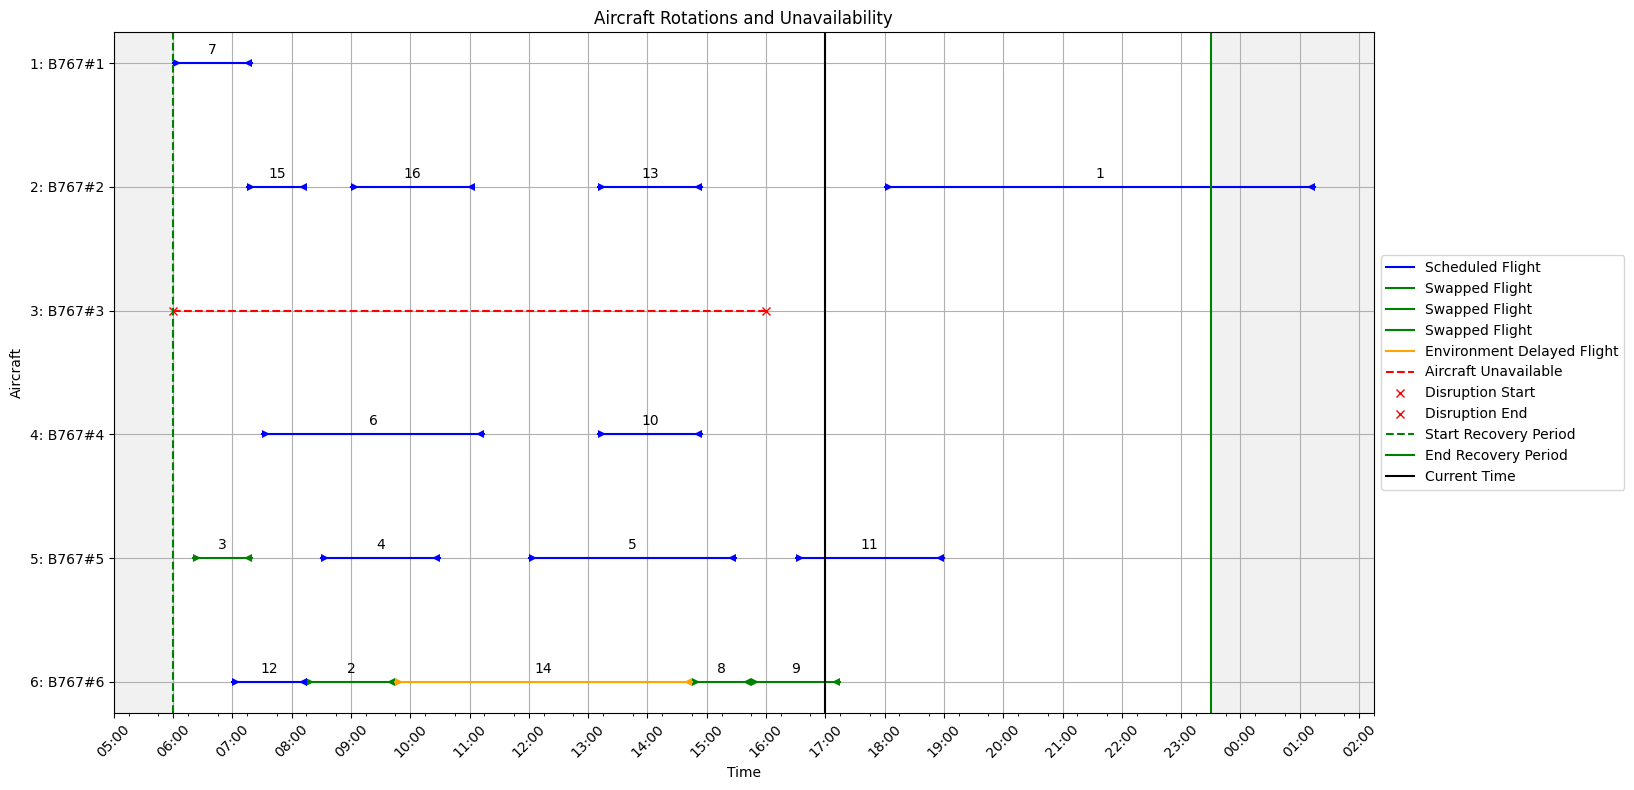

/Users/pieterbecking/.pyenv/versions/thesis_env/lib/python3.10/site-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:108: RuntimeWarning: invalid value encountered in cast
  self.buf_obs[key][env_idx] = obs


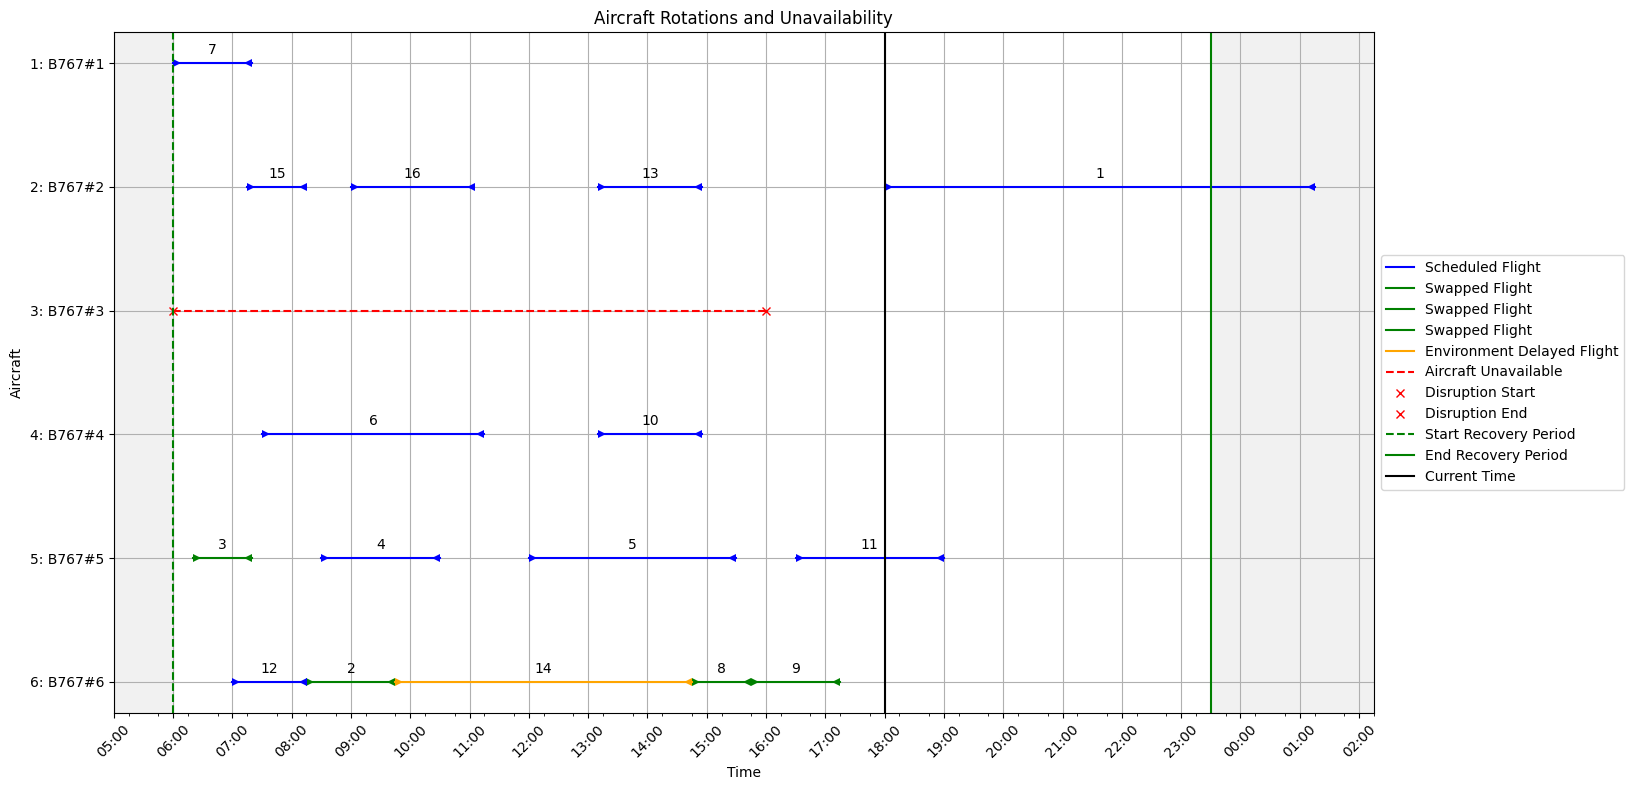

/Users/pieterbecking/.pyenv/versions/thesis_env/lib/python3.10/site-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:108: RuntimeWarning: invalid value encountered in cast
  self.buf_obs[key][env_idx] = obs


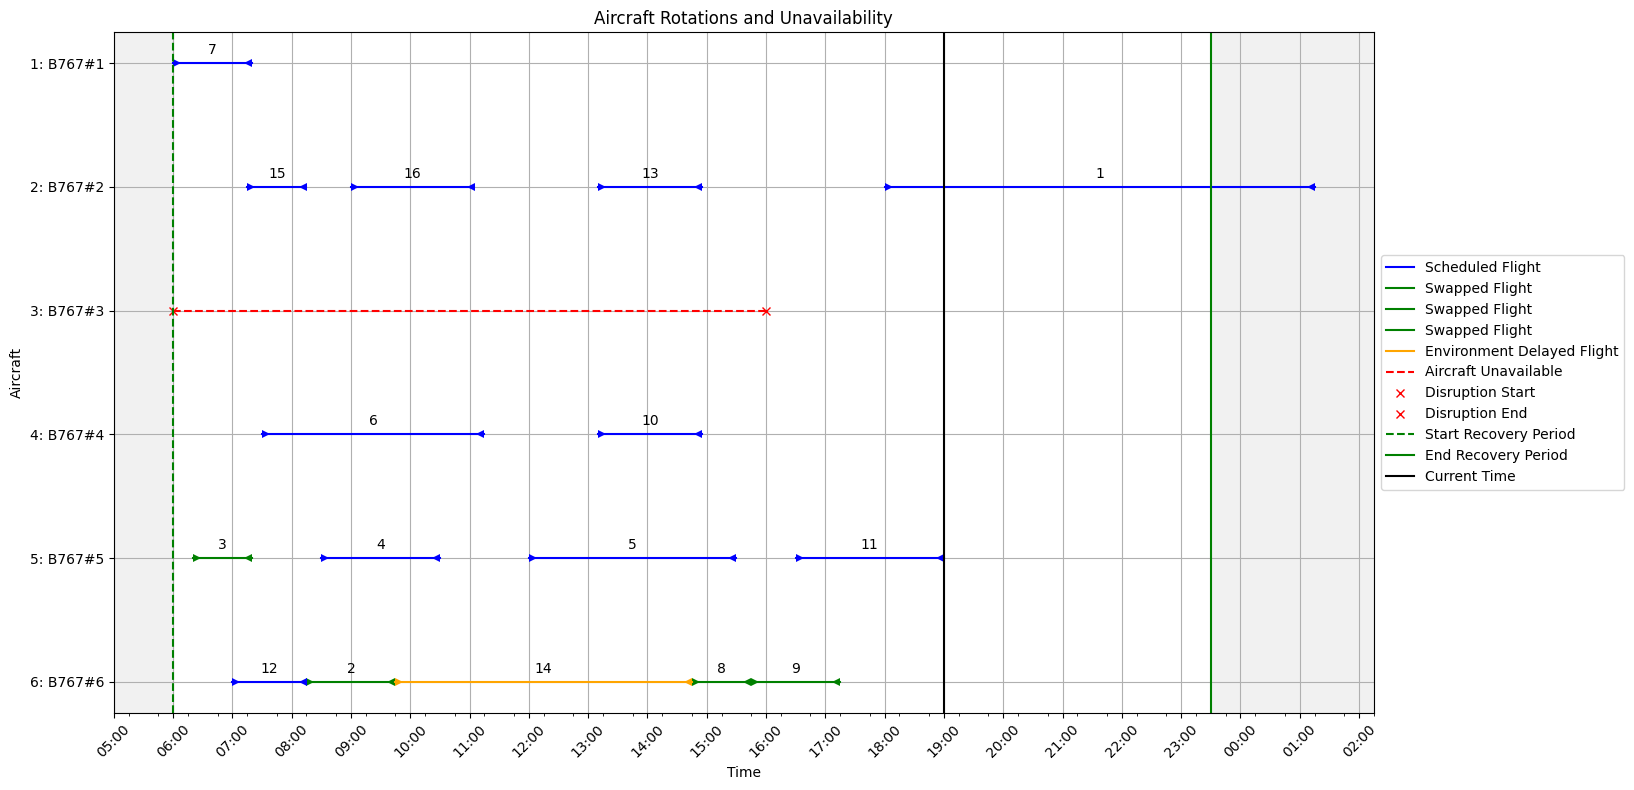

/Users/pieterbecking/.pyenv/versions/thesis_env/lib/python3.10/site-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:108: RuntimeWarning: invalid value encountered in cast
  self.buf_obs[key][env_idx] = obs


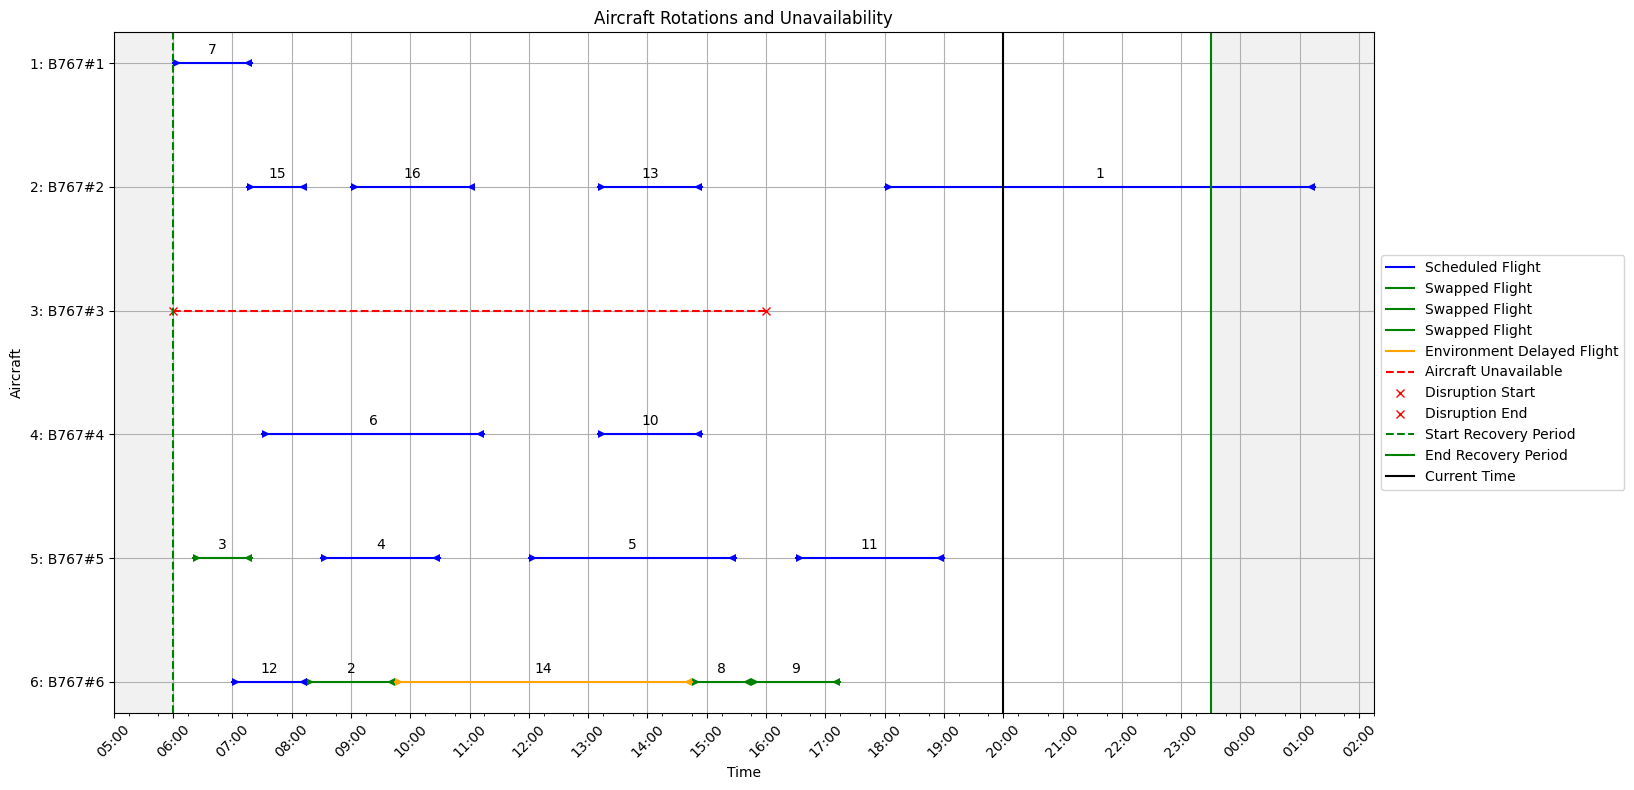

/Users/pieterbecking/.pyenv/versions/thesis_env/lib/python3.10/site-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:108: RuntimeWarning: invalid value encountered in cast
  self.buf_obs[key][env_idx] = obs


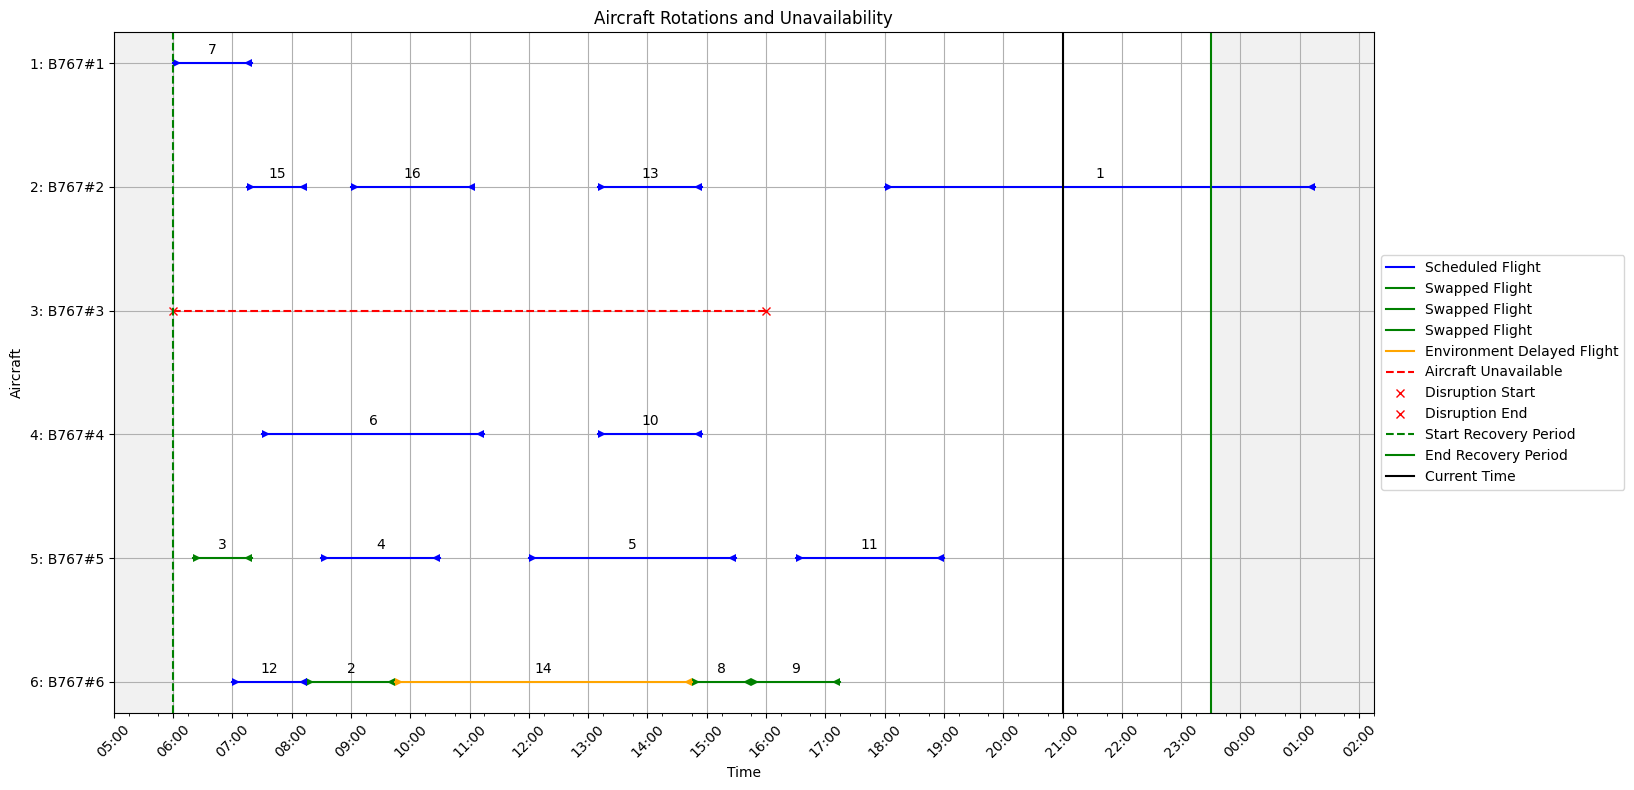

/Users/pieterbecking/.pyenv/versions/thesis_env/lib/python3.10/site-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:108: RuntimeWarning: invalid value encountered in cast
  self.buf_obs[key][env_idx] = obs


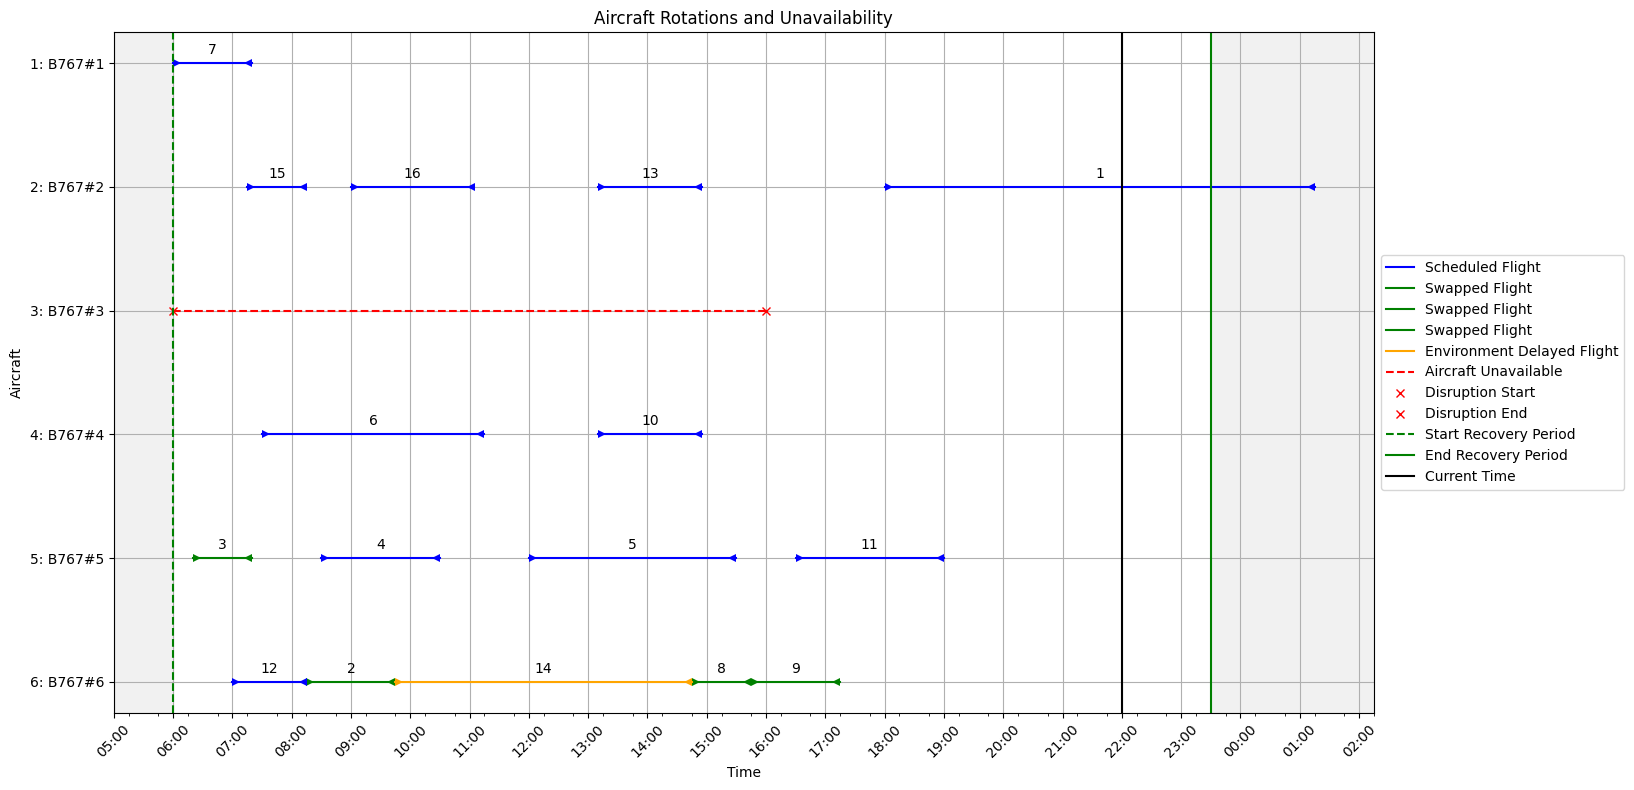

/Users/pieterbecking/.pyenv/versions/thesis_env/lib/python3.10/site-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:108: RuntimeWarning: invalid value encountered in cast
  self.buf_obs[key][env_idx] = obs


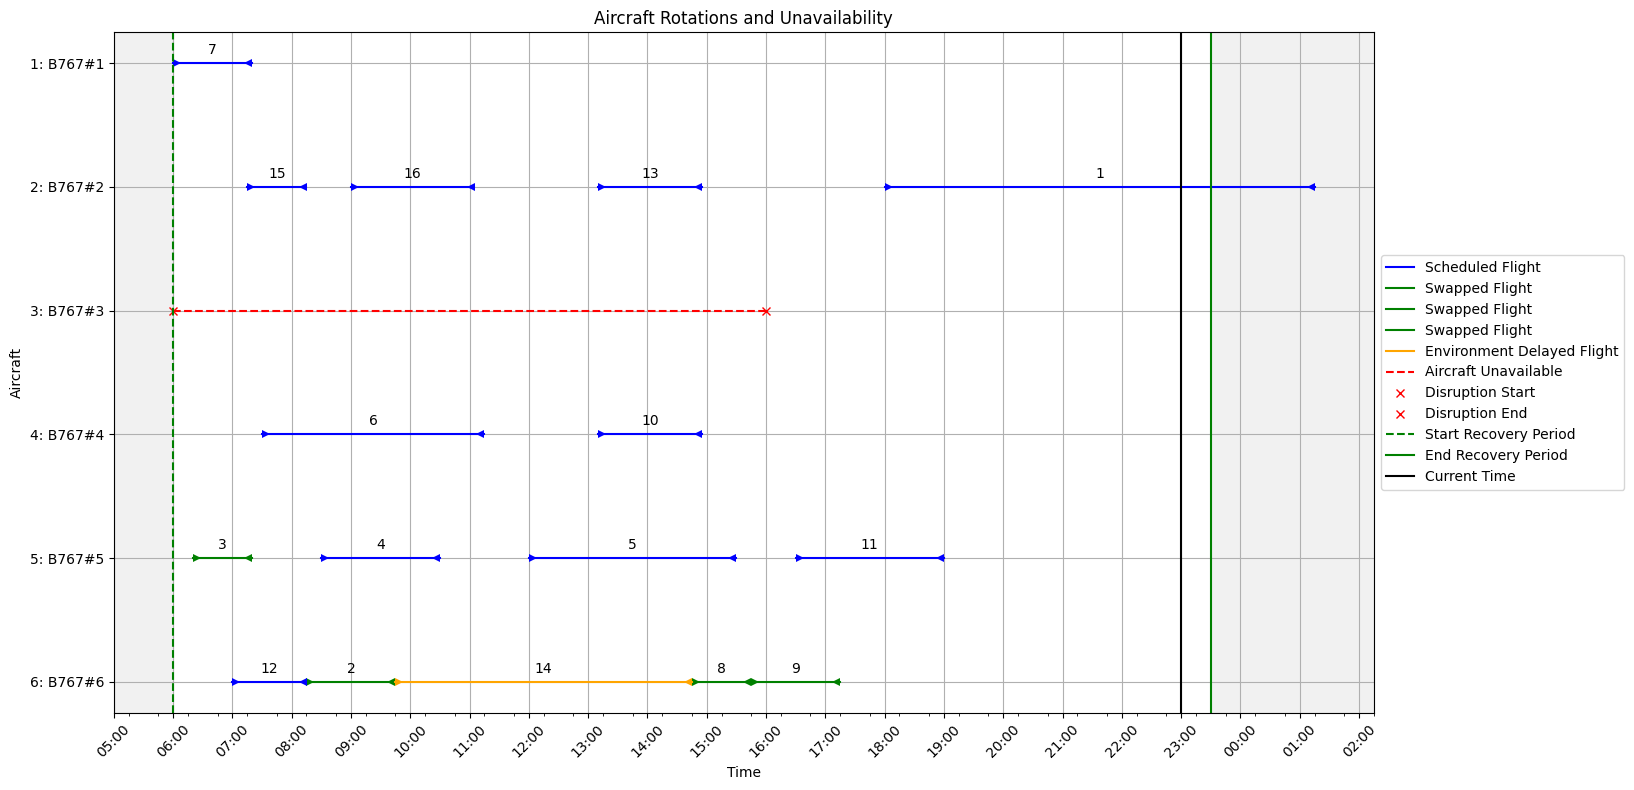

/Users/pieterbecking/.pyenv/versions/thesis_env/lib/python3.10/site-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:108: RuntimeWarning: invalid value encountered in cast
  self.buf_obs[key][env_idx] = obs


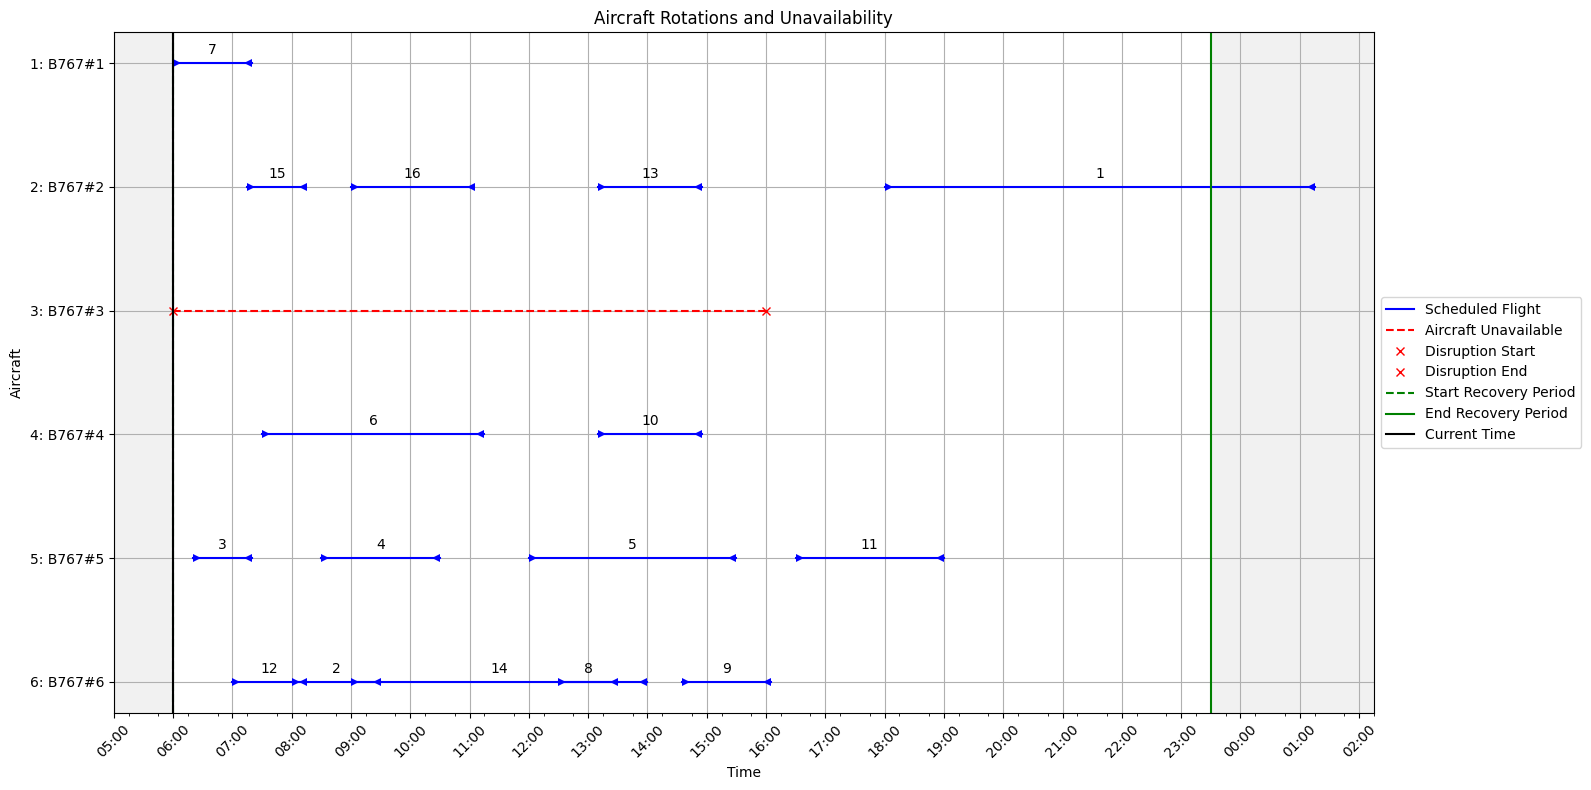

In [24]:
# Load the trained model and do one episode of evaluation
model = DQN.load("dqn_aircraft_disruption")

# Evaluate the trained model
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"Mean reward: {mean_reward} +/- {std_reward}")

# Access the underlying environment
real_env = env.envs[0]

# plot every step of one episode
obs = env.reset()
done = False


# plot initial state

state_plotter = StatePlotter(
    aircraft_dict, flights_dict, rotations_dict, alt_aircraft_dict, 
    real_env.start_datetime, real_env.end_datetime
)
state_plotter.plot_state(
    real_env.flights_dict, real_env.swapped_flights, 
    real_env.environment_delayed_flights, real_env.current_datetime
)

total_reward = 0
while not done:
    action, _ = model.predict(obs, deterministic=False)
    obs, reward, done, _ = env.step(action)

    # Plot the state of the environment
    state_plotter = StatePlotter(
        aircraft_dict, flights_dict, rotations_dict, alt_aircraft_dict, 
        real_env.start_datetime, real_env.end_datetime
    )
    state_plotter.plot_state(
        real_env.flights_dict, real_env.swapped_flights, 
        real_env.environment_delayed_flights, real_env.current_datetime
    )
    total_reward += reward
    
    print("Reward:", reward)
    print("Cumulative Reward:", total_reward)
    print("Action:", action)
    
print("Total Reward:", total_reward)